<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor, Pool, cv
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

In [2]:
taxi = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Периодичность в данных 10 минут, сделаем ресемплирование по 1 часу

In [4]:
#сделали ресемплирование по 1 часу
taxi_res = taxi.resample('1H').sum()
taxi_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод: 

    -в начале перевели в тип Datetime из object и сделали индексом для удобства;

    -так же отсортировали данные по дате;

    -после этого провели ресемплинг с диапозоном в 1 час ,где данные суммировались.

## Анализ

Посмотрим на графике тренд и сезонность:

In [5]:
decomposed = seasonal_decompose(taxi_res)

decomposed_week_mar = seasonal_decompose(taxi_res['2018-03-04':'2018-03-12'])
decomposed_week_jun = seasonal_decompose(taxi_res['2018-06-03':'2018-06-11'])
decomposed_month_apr = seasonal_decompose(taxi_res['2018-04-01':'2018-05-01'])
decomposed_month_aug = seasonal_decompose(taxi_res['2018-08-01':'2018-09-01'])

<AxesSubplot:xlabel='datetime'>

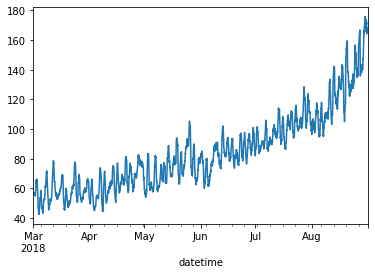

In [6]:
decomposed.trend.plot()

На графике видно, что с апреля по август заказы увеличиваются.

<AxesSubplot:xlabel='datetime'>

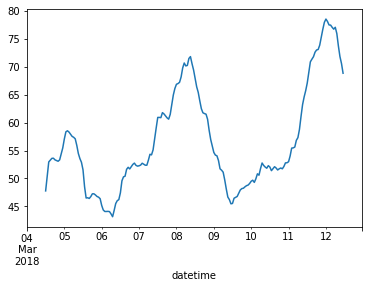

In [7]:
#посмотрим неделю в марте
decomposed_week_mar.trend.plot()

На графике с 5 по 11 марта 2018 г. мы видим, что большим спросом такси пользуются вначале недели (понедельник) и в середине(среда), малым спросом во вторник, субботу и в воскресение Возможно это связанно с тем, что в выходные у всех активный образ жизни: гуляют, катаются на велосипедах и т.д. А в понедельник некоторые просыпают на работу и пользуются такси.

<AxesSubplot:xlabel='datetime'>

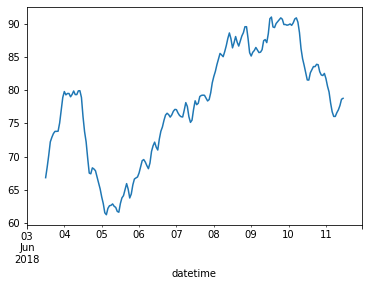

In [8]:
#посмотрим неделю в июне
decomposed_week_jun.trend.plot()

Тренд июня отличается с мартом, маленький спрос только во вторник.

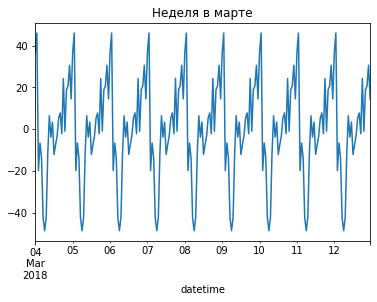

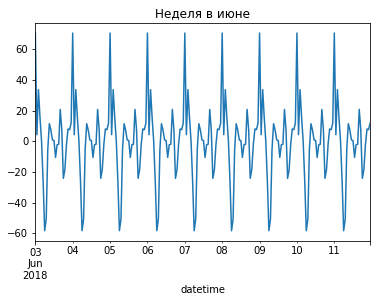

In [9]:
decomposed_week_mar.seasonal.plot()
plt.title('Неделя в марте')
plt.show()

decomposed_week_jun.seasonal.plot()
plt.title('Неделя в июне')
plt.show()

Сезонность одинаковая. Посмотрим сезонность за 2 дня.

<AxesSubplot:xlabel='datetime'>

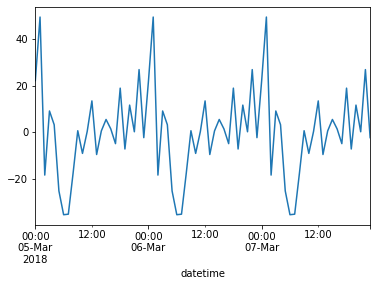

In [10]:
decomposed_day_mar = seasonal_decompose(taxi_res['2018-03-05':'2018-03-07'])
decomposed_day_mar.seasonal.plot()

На графике видно, что ночью спрос падает; с часов 7, 8 увеличивается и ближе к ночи достигает самых максимальных показателей.

Теперь посмотрим показатели по месяцам (апрель и август):

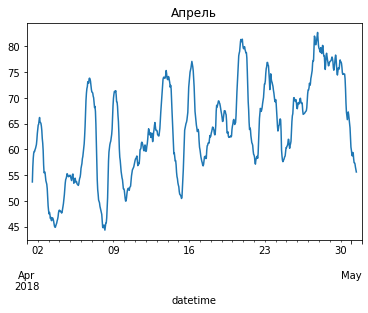

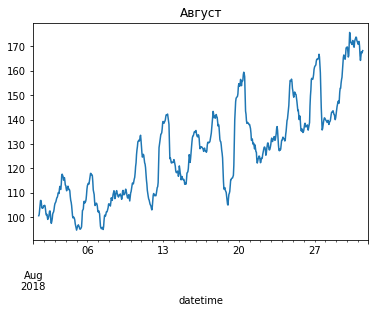

In [11]:
decomposed_month_apr.trend.plot()
plt.title('Апрель')
plt.show()
decomposed_month_aug.trend.plot()
plt.title('Август')
plt.show()

В обоих графиках с каждым днем увеличивается спрос на такси, но больше всего заказывают такси в августе, нежели весной. Летом все наслаждаются теплом и прогуливаются, а потом заказывают такси, если устали, до дома. 

Теперь создадим признаки для прогнозирования. В нашем случае это будет часы и дни недели. Так же получим отстающие значения и вычислим скользящее среднее.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(taxi_res, 2, 24)
taxi_res.head()

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN


## Обучение моделей

Рассмотрим 3 модели:
    
    - LinearRegression;
    - CatBoost;
    - LightGBM.
    
Но вначале разобьем данные на выборки.

In [14]:
train, test = train_test_split(taxi_res, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

### LinearRegression

In [16]:
mod_lr = LinearRegression()
mod_lr.fit(train_features, train_target)
pred = mod_lr.predict(test_features)
print('RMSE модели LinearRegression: ', mean_squared_error(test_target,pred) ** 0.5)

RMSE модели LinearRegression:  51.26866698864005


### CatBoost

In [17]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [18]:
modelCat = CatBoostRegressor(random_state = 12345)

param_search = {'depth' : [3, 5, 7],
                'learning_rate' : [0.01, 0.25, 0.5],
                'iterations' : [50, 100, 150]
               }

tscv = TimeSeriesSplit(n_splits=8)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv,
                        param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearchCat.fit(train_features, train_target)

0:	learn: 29.0986176	total: 51.6ms	remaining: 2.53s
1:	learn: 28.9775699	total: 52.2ms	remaining: 1.25s
2:	learn: 28.8582225	total: 52.6ms	remaining: 823ms
3:	learn: 28.7197222	total: 52.9ms	remaining: 609ms
4:	learn: 28.5975294	total: 53.3ms	remaining: 480ms
5:	learn: 28.4853874	total: 53.7ms	remaining: 394ms
6:	learn: 28.3504579	total: 54.1ms	remaining: 332ms
7:	learn: 28.2347347	total: 54.5ms	remaining: 286ms
8:	learn: 28.1465011	total: 54.8ms	remaining: 250ms
9:	learn: 28.0206389	total: 55.2ms	remaining: 221ms
10:	learn: 27.9058659	total: 55.6ms	remaining: 197ms
11:	learn: 27.7999404	total: 56ms	remaining: 177ms
12:	learn: 27.6932155	total: 56.4ms	remaining: 160ms
13:	learn: 27.5714757	total: 56.7ms	remaining: 146ms
14:	learn: 27.4657180	total: 57.1ms	remaining: 133ms
15:	learn: 27.3583865	total: 57.5ms	remaining: 122ms
16:	learn: 27.2703071	total: 57.9ms	remaining: 112ms
17:	learn: 27.1957207	total: 58.2ms	remaining: 104ms
18:	learn: 27.1206179	total: 58.6ms	remaining: 95.6ms
19:	

31:	learn: 28.6329282	total: 16.9ms	remaining: 9.53ms
32:	learn: 28.5539228	total: 17.7ms	remaining: 9.1ms
33:	learn: 28.4761580	total: 18.3ms	remaining: 8.61ms
34:	learn: 28.4191065	total: 18.9ms	remaining: 8.1ms
35:	learn: 28.3547065	total: 19.4ms	remaining: 7.55ms
36:	learn: 28.3031566	total: 20ms	remaining: 7.01ms
37:	learn: 28.2338095	total: 20.5ms	remaining: 6.48ms
38:	learn: 28.1603928	total: 21ms	remaining: 5.92ms
39:	learn: 28.1007801	total: 21.5ms	remaining: 5.36ms
40:	learn: 28.0492816	total: 22ms	remaining: 4.82ms
41:	learn: 27.9979199	total: 22.5ms	remaining: 4.28ms
42:	learn: 27.9142244	total: 23ms	remaining: 3.74ms
43:	learn: 27.8478635	total: 23.4ms	remaining: 3.2ms
44:	learn: 27.7870741	total: 23.9ms	remaining: 2.66ms
45:	learn: 27.7275545	total: 24.4ms	remaining: 2.13ms
46:	learn: 27.6775525	total: 24.9ms	remaining: 1.59ms
47:	learn: 27.6130965	total: 25.4ms	remaining: 1.06ms
48:	learn: 27.5333458	total: 26ms	remaining: 530us
49:	learn: 27.4596347	total: 26.6ms	remain

21:	learn: 16.2501868	total: 7.85ms	remaining: 9.99ms
22:	learn: 16.1053732	total: 8.26ms	remaining: 9.7ms
23:	learn: 16.0069324	total: 8.62ms	remaining: 9.34ms
24:	learn: 15.9044027	total: 9.03ms	remaining: 9.03ms
25:	learn: 15.8254734	total: 9.39ms	remaining: 8.67ms
26:	learn: 15.7066928	total: 9.71ms	remaining: 8.28ms
27:	learn: 15.6521553	total: 10ms	remaining: 7.89ms
28:	learn: 15.5589046	total: 10.4ms	remaining: 7.52ms
29:	learn: 15.4801452	total: 10.7ms	remaining: 7.14ms
30:	learn: 15.4164761	total: 11.1ms	remaining: 6.78ms
31:	learn: 15.3733377	total: 11.4ms	remaining: 6.42ms
32:	learn: 15.3013692	total: 11.7ms	remaining: 6.05ms
33:	learn: 15.2251732	total: 12.1ms	remaining: 5.67ms
34:	learn: 15.0745244	total: 12.4ms	remaining: 5.31ms
35:	learn: 15.0205434	total: 12.7ms	remaining: 4.94ms
36:	learn: 14.9584830	total: 13ms	remaining: 4.58ms
37:	learn: 14.8832786	total: 13.4ms	remaining: 4.22ms
38:	learn: 14.8562020	total: 13.7ms	remaining: 3.87ms
39:	learn: 14.8166466	total: 14ms

45:	learn: 20.3100406	total: 28.4ms	remaining: 2.47ms
46:	learn: 20.2252779	total: 29.2ms	remaining: 1.87ms
47:	learn: 20.1245639	total: 30.1ms	remaining: 1.25ms
48:	learn: 20.0884073	total: 30.8ms	remaining: 628us
49:	learn: 20.0483363	total: 31.5ms	remaining: 0us
0:	learn: 31.3907314	total: 598us	remaining: 29.3ms
1:	learn: 29.9119056	total: 1.34ms	remaining: 32.1ms
2:	learn: 28.0854818	total: 1.97ms	remaining: 30.9ms
3:	learn: 27.0979259	total: 2.6ms	remaining: 29.9ms
4:	learn: 25.9647471	total: 3.23ms	remaining: 29.1ms
5:	learn: 25.3384448	total: 3.83ms	remaining: 28.1ms
6:	learn: 24.9008412	total: 4.53ms	remaining: 27.8ms
7:	learn: 24.5649506	total: 5.31ms	remaining: 27.9ms
8:	learn: 24.3812503	total: 6.07ms	remaining: 27.6ms
9:	learn: 23.9263908	total: 6.7ms	remaining: 26.8ms
10:	learn: 23.6645240	total: 7.39ms	remaining: 26.2ms
11:	learn: 23.3707951	total: 8.13ms	remaining: 25.7ms
12:	learn: 23.2504018	total: 8.8ms	remaining: 25.1ms
13:	learn: 22.9944075	total: 9.44ms	remaining:

1:	learn: 24.7283406	total: 1.36ms	remaining: 32.6ms
2:	learn: 23.6832206	total: 1.95ms	remaining: 30.5ms
3:	learn: 22.6420177	total: 2.58ms	remaining: 29.6ms
4:	learn: 21.9074213	total: 3.18ms	remaining: 28.6ms
5:	learn: 21.3899362	total: 3.69ms	remaining: 27.1ms
6:	learn: 21.2328188	total: 4.17ms	remaining: 25.6ms
7:	learn: 21.0432657	total: 4.66ms	remaining: 24.5ms
8:	learn: 20.9371324	total: 5.17ms	remaining: 23.6ms
9:	learn: 20.6642555	total: 5.73ms	remaining: 22.9ms
10:	learn: 20.4191818	total: 6.25ms	remaining: 22.2ms
11:	learn: 20.2477395	total: 6.74ms	remaining: 21.3ms
12:	learn: 20.0149675	total: 7.22ms	remaining: 20.6ms
13:	learn: 19.8487140	total: 7.68ms	remaining: 19.7ms
14:	learn: 19.6535674	total: 8.18ms	remaining: 19.1ms
15:	learn: 19.5045864	total: 8.64ms	remaining: 18.4ms
16:	learn: 19.4024930	total: 9.11ms	remaining: 17.7ms
17:	learn: 19.3388813	total: 9.68ms	remaining: 17.2ms
18:	learn: 19.2464237	total: 10.3ms	remaining: 16.8ms
19:	learn: 19.1430189	total: 11ms	rem

47:	learn: 19.9179265	total: 31.7ms	remaining: 1.32ms
48:	learn: 19.8638969	total: 32.4ms	remaining: 661us
49:	learn: 19.7789976	total: 33.2ms	remaining: 0us
0:	learn: 29.0986176	total: 343us	remaining: 34ms
1:	learn: 28.9775699	total: 726us	remaining: 35.6ms
2:	learn: 28.8582225	total: 1.09ms	remaining: 35.2ms
3:	learn: 28.7197222	total: 1.4ms	remaining: 33.7ms
4:	learn: 28.5975294	total: 1.71ms	remaining: 32.4ms
5:	learn: 28.4853874	total: 2.02ms	remaining: 31.7ms
6:	learn: 28.3504579	total: 2.34ms	remaining: 31.1ms
7:	learn: 28.2347347	total: 2.77ms	remaining: 31.9ms
8:	learn: 28.1465011	total: 3.17ms	remaining: 32ms
9:	learn: 28.0206389	total: 3.49ms	remaining: 31.4ms
10:	learn: 27.9058659	total: 3.81ms	remaining: 30.8ms
11:	learn: 27.7999404	total: 4.12ms	remaining: 30.2ms
12:	learn: 27.6932155	total: 4.44ms	remaining: 29.7ms
13:	learn: 27.5714757	total: 4.76ms	remaining: 29.3ms
14:	learn: 27.4657180	total: 5.09ms	remaining: 28.8ms
15:	learn: 27.3583865	total: 5.4ms	remaining: 28.

39:	learn: 28.1007801	total: 20.2ms	remaining: 30.2ms
40:	learn: 28.0492816	total: 20.8ms	remaining: 30ms
41:	learn: 27.9979199	total: 21.5ms	remaining: 29.6ms
42:	learn: 27.9142244	total: 22.1ms	remaining: 29.2ms
43:	learn: 27.8478635	total: 22.7ms	remaining: 28.9ms
44:	learn: 27.7870741	total: 23.2ms	remaining: 28.4ms
45:	learn: 27.7275545	total: 23.7ms	remaining: 27.9ms
46:	learn: 27.6775525	total: 24.2ms	remaining: 27.3ms
47:	learn: 27.6130965	total: 24.7ms	remaining: 26.7ms
48:	learn: 27.5333458	total: 25.1ms	remaining: 26.1ms
49:	learn: 27.4596347	total: 25.6ms	remaining: 25.6ms
50:	learn: 27.4077785	total: 26ms	remaining: 25ms
51:	learn: 27.3575856	total: 26.6ms	remaining: 24.6ms
52:	learn: 27.3020431	total: 27.1ms	remaining: 24ms
53:	learn: 27.2547211	total: 27.7ms	remaining: 23.6ms
54:	learn: 27.1944302	total: 28.4ms	remaining: 23.2ms
55:	learn: 27.1455676	total: 28.9ms	remaining: 22.7ms
56:	learn: 27.1071209	total: 29.3ms	remaining: 22.1ms
57:	learn: 27.0524275	total: 29.8ms	

9:	learn: 33.0200926	total: 7.29ms	remaining: 65.6ms
10:	learn: 32.9286504	total: 8.41ms	remaining: 68.1ms
11:	learn: 32.8168712	total: 9.45ms	remaining: 69.3ms
12:	learn: 32.7169523	total: 10.2ms	remaining: 68.6ms
13:	learn: 32.6244314	total: 10.9ms	remaining: 67ms
14:	learn: 32.5339204	total: 11.8ms	remaining: 67.1ms
15:	learn: 32.4357994	total: 12.7ms	remaining: 66.7ms
16:	learn: 32.3315845	total: 13.4ms	remaining: 65.6ms
17:	learn: 32.2457441	total: 14.1ms	remaining: 64.2ms
18:	learn: 32.1472923	total: 14.9ms	remaining: 63.3ms
19:	learn: 32.0649273	total: 15.5ms	remaining: 62.2ms
20:	learn: 31.9815740	total: 16.1ms	remaining: 60.7ms
21:	learn: 31.9032063	total: 16.8ms	remaining: 59.5ms
22:	learn: 31.8112774	total: 17.6ms	remaining: 58.8ms
23:	learn: 31.7321643	total: 18.1ms	remaining: 57.3ms
24:	learn: 31.6436228	total: 18.8ms	remaining: 56.3ms
25:	learn: 31.5453151	total: 19.4ms	remaining: 55.2ms
26:	learn: 31.4491696	total: 20ms	remaining: 54.2ms
27:	learn: 31.3532543	total: 20.7

39:	learn: 14.8166466	total: 14.8ms	remaining: 22.2ms
40:	learn: 14.7551783	total: 15.3ms	remaining: 21.9ms
41:	learn: 14.7083203	total: 16ms	remaining: 22ms
42:	learn: 14.6722931	total: 16.4ms	remaining: 21.7ms
43:	learn: 14.6105616	total: 16.8ms	remaining: 21.3ms
44:	learn: 14.6053318	total: 17.2ms	remaining: 21ms
45:	learn: 14.4770214	total: 17.5ms	remaining: 20.5ms
46:	learn: 14.3879685	total: 17.8ms	remaining: 20.1ms
47:	learn: 14.2919346	total: 18.2ms	remaining: 19.7ms
48:	learn: 14.2403489	total: 18.5ms	remaining: 19.2ms
49:	learn: 14.1438254	total: 18.8ms	remaining: 18.8ms
50:	learn: 14.0885910	total: 19.2ms	remaining: 18.5ms
51:	learn: 14.0346405	total: 19.5ms	remaining: 18ms
52:	learn: 13.9880442	total: 19.8ms	remaining: 17.6ms
53:	learn: 13.9376592	total: 20.2ms	remaining: 17.2ms
54:	learn: 13.8764896	total: 20.5ms	remaining: 16.8ms
55:	learn: 13.8242135	total: 20.9ms	remaining: 16.4ms
56:	learn: 13.7756589	total: 21.3ms	remaining: 16ms
57:	learn: 13.7080172	total: 21.8ms	re

76:	learn: 17.6986039	total: 36.4ms	remaining: 10.9ms
77:	learn: 17.6751548	total: 37ms	remaining: 10.4ms
78:	learn: 17.6456824	total: 37.6ms	remaining: 9.99ms
79:	learn: 17.5964772	total: 38.1ms	remaining: 9.54ms
80:	learn: 17.5495471	total: 38.6ms	remaining: 9.06ms
81:	learn: 17.5285151	total: 39.1ms	remaining: 8.59ms
82:	learn: 17.4902152	total: 39.6ms	remaining: 8.11ms
83:	learn: 17.4665475	total: 40.1ms	remaining: 7.63ms
84:	learn: 17.4469021	total: 40.5ms	remaining: 7.16ms
85:	learn: 17.4153375	total: 41ms	remaining: 6.68ms
86:	learn: 17.3967367	total: 41.5ms	remaining: 6.2ms
87:	learn: 17.3727067	total: 42ms	remaining: 5.72ms
88:	learn: 17.3409311	total: 42.4ms	remaining: 5.24ms
89:	learn: 17.3123809	total: 42.9ms	remaining: 4.76ms
90:	learn: 17.2677687	total: 43.4ms	remaining: 4.29ms
91:	learn: 17.2336246	total: 43.8ms	remaining: 3.81ms
92:	learn: 17.2016629	total: 44.3ms	remaining: 3.34ms
93:	learn: 17.1830850	total: 44.9ms	remaining: 2.86ms
94:	learn: 17.1678908	total: 45.4ms

39:	learn: 21.0780486	total: 24.7ms	remaining: 37ms
40:	learn: 21.0331607	total: 25.4ms	remaining: 36.5ms
41:	learn: 20.9002024	total: 26.1ms	remaining: 36.1ms
42:	learn: 20.8068369	total: 26.8ms	remaining: 35.5ms
43:	learn: 20.7758709	total: 27.4ms	remaining: 34.8ms
44:	learn: 20.6894833	total: 28ms	remaining: 34.2ms
45:	learn: 20.6179219	total: 28.6ms	remaining: 33.6ms
46:	learn: 20.5533501	total: 29.2ms	remaining: 32.9ms
47:	learn: 20.5097009	total: 29.8ms	remaining: 32.3ms
48:	learn: 20.4248057	total: 30.6ms	remaining: 31.8ms
49:	learn: 20.3924404	total: 31.2ms	remaining: 31.2ms
50:	learn: 20.3533496	total: 31.8ms	remaining: 30.6ms
51:	learn: 20.3086747	total: 32.4ms	remaining: 29.9ms
52:	learn: 20.2575884	total: 33ms	remaining: 29.3ms
53:	learn: 20.2080011	total: 33.6ms	remaining: 28.7ms
54:	learn: 20.1744924	total: 34.3ms	remaining: 28ms
55:	learn: 20.1399947	total: 34.9ms	remaining: 27.4ms
56:	learn: 20.1261441	total: 35.6ms	remaining: 26.8ms
57:	learn: 20.0695196	total: 36.3ms	

7:	learn: 19.4902598	total: 3.16ms	remaining: 36.3ms
8:	learn: 19.3964020	total: 3.87ms	remaining: 39.1ms
9:	learn: 19.2327372	total: 4.26ms	remaining: 38.3ms
10:	learn: 18.9035973	total: 4.88ms	remaining: 39.5ms
11:	learn: 18.7697610	total: 5.29ms	remaining: 38.8ms
12:	learn: 18.5618823	total: 5.7ms	remaining: 38.2ms
13:	learn: 18.3353204	total: 6.07ms	remaining: 37.3ms
14:	learn: 18.1320015	total: 6.43ms	remaining: 36.5ms
15:	learn: 17.8971006	total: 6.8ms	remaining: 35.7ms
16:	learn: 17.7462168	total: 7.16ms	remaining: 35ms
17:	learn: 17.5069011	total: 7.5ms	remaining: 34.2ms
18:	learn: 17.4026005	total: 7.85ms	remaining: 33.5ms
19:	learn: 17.2327598	total: 8.21ms	remaining: 32.8ms
20:	learn: 17.1450365	total: 8.62ms	remaining: 32.4ms
21:	learn: 17.0587477	total: 9.01ms	remaining: 31.9ms
22:	learn: 16.8356495	total: 9.43ms	remaining: 31.6ms
23:	learn: 16.6522445	total: 9.84ms	remaining: 31.1ms
24:	learn: 16.4999493	total: 10.2ms	remaining: 30.6ms
25:	learn: 16.3635509	total: 10.7ms	

8:	learn: 22.2064482	total: 5.77ms	remaining: 58.4ms
9:	learn: 21.8715392	total: 6.88ms	remaining: 61.9ms
10:	learn: 21.4974914	total: 7.5ms	remaining: 60.7ms
11:	learn: 21.3762984	total: 8.14ms	remaining: 59.7ms
12:	learn: 21.2772332	total: 8.73ms	remaining: 58.4ms
13:	learn: 21.1631529	total: 9.32ms	remaining: 57.3ms
14:	learn: 21.0349772	total: 9.87ms	remaining: 55.9ms
15:	learn: 20.8749945	total: 10.4ms	remaining: 54.7ms
16:	learn: 20.8316867	total: 11ms	remaining: 53.7ms
17:	learn: 20.7148693	total: 11.5ms	remaining: 52.6ms
18:	learn: 20.6319078	total: 12.1ms	remaining: 51.5ms
19:	learn: 20.5741359	total: 12.6ms	remaining: 50.4ms
20:	learn: 20.3466897	total: 13.2ms	remaining: 49.7ms
21:	learn: 20.1990452	total: 13.8ms	remaining: 48.9ms
22:	learn: 20.0629588	total: 14.3ms	remaining: 48ms
23:	learn: 19.9283914	total: 14.8ms	remaining: 47ms
24:	learn: 19.7457014	total: 15.4ms	remaining: 46.1ms
25:	learn: 19.5773584	total: 15.9ms	remaining: 45.2ms
26:	learn: 19.4482220	total: 16.4ms	r

60:	learn: 18.6249644	total: 40.7ms	remaining: 26ms
61:	learn: 18.5995142	total: 41.4ms	remaining: 25.4ms
62:	learn: 18.5703907	total: 42.1ms	remaining: 24.7ms
63:	learn: 18.5441850	total: 42.9ms	remaining: 24.1ms
64:	learn: 18.5289703	total: 43.7ms	remaining: 23.6ms
65:	learn: 18.5099340	total: 44.6ms	remaining: 23ms
66:	learn: 18.5010441	total: 45.2ms	remaining: 22.3ms
67:	learn: 18.4881938	total: 45.9ms	remaining: 21.6ms
68:	learn: 18.4616448	total: 46.6ms	remaining: 20.9ms
69:	learn: 18.4497021	total: 47.3ms	remaining: 20.3ms
70:	learn: 18.4119378	total: 48ms	remaining: 19.6ms
71:	learn: 18.3790752	total: 48.8ms	remaining: 19ms
72:	learn: 18.3682850	total: 49.5ms	remaining: 18.3ms
73:	learn: 18.3374688	total: 50.1ms	remaining: 17.6ms
74:	learn: 18.2882970	total: 50.8ms	remaining: 16.9ms
75:	learn: 18.2704692	total: 51.4ms	remaining: 16.2ms
76:	learn: 18.2365554	total: 52ms	remaining: 15.5ms
77:	learn: 18.2340986	total: 52.6ms	remaining: 14.8ms
78:	learn: 18.2103135	total: 53.2ms	re

138:	learn: 20.8093140	total: 52.8ms	remaining: 4.18ms
139:	learn: 20.7883798	total: 53.2ms	remaining: 3.8ms
140:	learn: 20.7569852	total: 53.6ms	remaining: 3.42ms
141:	learn: 20.7377163	total: 54ms	remaining: 3.04ms
142:	learn: 20.7168289	total: 54.4ms	remaining: 2.66ms
143:	learn: 20.6986304	total: 54.7ms	remaining: 2.28ms
144:	learn: 20.6671423	total: 55ms	remaining: 1.9ms
145:	learn: 20.6485905	total: 55.4ms	remaining: 1.52ms
146:	learn: 20.6259856	total: 55.7ms	remaining: 1.14ms
147:	learn: 20.6110863	total: 56ms	remaining: 757us
148:	learn: 20.5922894	total: 56.4ms	remaining: 378us
149:	learn: 20.5747730	total: 56.7ms	remaining: 0us
0:	learn: 29.3601831	total: 330us	remaining: 49.3ms
1:	learn: 29.2433501	total: 794us	remaining: 58.8ms
2:	learn: 29.1332360	total: 1.33ms	remaining: 65.3ms
3:	learn: 29.0076358	total: 1.72ms	remaining: 62.7ms
4:	learn: 28.8910997	total: 2.12ms	remaining: 61.5ms
5:	learn: 28.8163186	total: 2.55ms	remaining: 61.1ms
6:	learn: 28.7017234	total: 2.96ms	re

0:	learn: 31.2894946	total: 478us	remaining: 71.3ms
1:	learn: 31.1861150	total: 1.17ms	remaining: 86.7ms
2:	learn: 31.0866352	total: 1.81ms	remaining: 88.7ms
3:	learn: 30.9781816	total: 2.49ms	remaining: 90.7ms
4:	learn: 30.9066569	total: 3.01ms	remaining: 87.2ms
5:	learn: 30.8290468	total: 3.52ms	remaining: 84.4ms
6:	learn: 30.7469684	total: 3.98ms	remaining: 81.3ms
7:	learn: 30.6595870	total: 4.47ms	remaining: 79.3ms
8:	learn: 30.5533986	total: 5.17ms	remaining: 81ms
9:	learn: 30.4521083	total: 5.83ms	remaining: 81.6ms
10:	learn: 30.3621395	total: 6.35ms	remaining: 80.2ms
11:	learn: 30.2502363	total: 6.88ms	remaining: 79.1ms
12:	learn: 30.1494172	total: 7.43ms	remaining: 78.3ms
13:	learn: 30.0508690	total: 7.99ms	remaining: 77.6ms
14:	learn: 29.9774672	total: 8.49ms	remaining: 76.4ms
15:	learn: 29.8807226	total: 9.03ms	remaining: 75.6ms
16:	learn: 29.7855569	total: 9.57ms	remaining: 74.9ms
17:	learn: 29.7141943	total: 10.1ms	remaining: 74.3ms
18:	learn: 29.6364676	total: 10.6ms	remai

124:	learn: 25.8667107	total: 77.6ms	remaining: 15.5ms
125:	learn: 25.8391208	total: 78.5ms	remaining: 15ms
126:	learn: 25.8138521	total: 79.7ms	remaining: 14.4ms
127:	learn: 25.7862509	total: 80.3ms	remaining: 13.8ms
128:	learn: 25.7631445	total: 80.9ms	remaining: 13.2ms
129:	learn: 25.7280048	total: 81.5ms	remaining: 12.5ms
130:	learn: 25.7010921	total: 82.1ms	remaining: 11.9ms
131:	learn: 25.6577907	total: 82.7ms	remaining: 11.3ms
132:	learn: 25.6331686	total: 83.3ms	remaining: 10.7ms
133:	learn: 25.6058783	total: 84ms	remaining: 10ms
134:	learn: 25.5803092	total: 84.6ms	remaining: 9.4ms
135:	learn: 25.5593160	total: 85.2ms	remaining: 8.77ms
136:	learn: 25.5427516	total: 85.8ms	remaining: 8.14ms
137:	learn: 25.5025989	total: 86.4ms	remaining: 7.51ms
138:	learn: 25.4674524	total: 86.9ms	remaining: 6.88ms
139:	learn: 25.4497119	total: 87.5ms	remaining: 6.25ms
140:	learn: 25.4151577	total: 88.3ms	remaining: 5.63ms
141:	learn: 25.3808302	total: 88.9ms	remaining: 5.01ms
142:	learn: 25.34

53:	learn: 29.5710826	total: 36.7ms	remaining: 65.2ms
54:	learn: 29.5141784	total: 37.7ms	remaining: 65.1ms
55:	learn: 29.4572148	total: 38.5ms	remaining: 64.7ms
56:	learn: 29.4029222	total: 39.3ms	remaining: 64.1ms
57:	learn: 29.3482171	total: 39.9ms	remaining: 63.3ms
58:	learn: 29.2943438	total: 40.6ms	remaining: 62.6ms
59:	learn: 29.2265406	total: 41.3ms	remaining: 61.9ms
60:	learn: 29.1584931	total: 41.9ms	remaining: 61.2ms
61:	learn: 29.1115916	total: 42.6ms	remaining: 60.5ms
62:	learn: 29.0596120	total: 43.2ms	remaining: 59.7ms
63:	learn: 28.9914433	total: 44ms	remaining: 59.2ms
64:	learn: 28.9289198	total: 44.6ms	remaining: 58.3ms
65:	learn: 28.8810595	total: 45.4ms	remaining: 57.8ms
66:	learn: 28.8372075	total: 46.1ms	remaining: 57ms
67:	learn: 28.7899837	total: 46.8ms	remaining: 56.4ms
68:	learn: 28.7407769	total: 47.5ms	remaining: 55.8ms
69:	learn: 28.6918313	total: 48.4ms	remaining: 55.4ms
70:	learn: 28.6466919	total: 49.2ms	remaining: 54.7ms
71:	learn: 28.5888849	total: 49.

134:	learn: 27.1012637	total: 93.1ms	remaining: 10.3ms
135:	learn: 27.0749647	total: 93.9ms	remaining: 9.67ms
136:	learn: 27.0506545	total: 94.7ms	remaining: 8.98ms
137:	learn: 27.0190215	total: 95.5ms	remaining: 8.3ms
138:	learn: 26.9962464	total: 96.2ms	remaining: 7.61ms
139:	learn: 26.9778278	total: 96.9ms	remaining: 6.92ms
140:	learn: 26.9328909	total: 97.6ms	remaining: 6.23ms
141:	learn: 26.8948061	total: 98.3ms	remaining: 5.54ms
142:	learn: 26.8662401	total: 99ms	remaining: 4.85ms
143:	learn: 26.8337845	total: 99.9ms	remaining: 4.16ms
144:	learn: 26.7969377	total: 101ms	remaining: 3.47ms
145:	learn: 26.7767124	total: 101ms	remaining: 2.77ms
146:	learn: 26.7583568	total: 102ms	remaining: 2.08ms
147:	learn: 26.7371326	total: 103ms	remaining: 1.39ms
148:	learn: 26.7067641	total: 103ms	remaining: 694us
149:	learn: 26.6712949	total: 104ms	remaining: 0us
0:	learn: 26.3850936	total: 390us	remaining: 58.2ms
1:	learn: 24.2914149	total: 839us	remaining: 62.1ms
2:	learn: 22.4944198	total: 1

6:	learn: 22.1284686	total: 3.62ms	remaining: 74ms
7:	learn: 21.8249235	total: 4.38ms	remaining: 77.7ms
8:	learn: 21.6408147	total: 4.82ms	remaining: 75.5ms
9:	learn: 21.3106932	total: 5.38ms	remaining: 75.3ms
10:	learn: 20.9841004	total: 5.86ms	remaining: 74.1ms
11:	learn: 20.8045540	total: 6.34ms	remaining: 73ms
12:	learn: 20.7085825	total: 7.03ms	remaining: 74ms
13:	learn: 20.5542330	total: 7.56ms	remaining: 73.5ms
14:	learn: 20.3946160	total: 8.16ms	remaining: 73.5ms
15:	learn: 20.2384092	total: 8.72ms	remaining: 73.1ms
16:	learn: 20.1042731	total: 9.27ms	remaining: 72.6ms
17:	learn: 20.0485290	total: 9.78ms	remaining: 71.7ms
18:	learn: 19.9377732	total: 10.3ms	remaining: 70.9ms
19:	learn: 19.8508704	total: 10.7ms	remaining: 69.8ms
20:	learn: 19.6402122	total: 11.2ms	remaining: 68.8ms
21:	learn: 19.5588025	total: 11.7ms	remaining: 67.8ms
22:	learn: 19.5314193	total: 12.1ms	remaining: 67ms
23:	learn: 19.4353325	total: 12.6ms	remaining: 66.1ms
24:	learn: 19.2465447	total: 13ms	remain

0:	learn: 30.2869775	total: 507us	remaining: 75.6ms
1:	learn: 28.6949269	total: 1.27ms	remaining: 94ms
2:	learn: 27.1380028	total: 2ms	remaining: 97.9ms
3:	learn: 25.9919731	total: 2.6ms	remaining: 94.9ms
4:	learn: 25.3946260	total: 3.16ms	remaining: 91.6ms
5:	learn: 24.8872260	total: 3.7ms	remaining: 88.8ms
6:	learn: 24.3428028	total: 4.26ms	remaining: 87ms
7:	learn: 24.0255083	total: 4.82ms	remaining: 85.6ms
8:	learn: 23.5878806	total: 5.44ms	remaining: 85.3ms
9:	learn: 23.3488351	total: 6.04ms	remaining: 84.5ms
10:	learn: 23.1712540	total: 6.69ms	remaining: 84.5ms
11:	learn: 22.8739208	total: 7.26ms	remaining: 83.5ms
12:	learn: 22.7439091	total: 8.14ms	remaining: 85.8ms
13:	learn: 22.5346623	total: 8.78ms	remaining: 85.3ms
14:	learn: 22.3920930	total: 9.52ms	remaining: 85.7ms
15:	learn: 22.1383655	total: 10.1ms	remaining: 84.9ms
16:	learn: 22.0479078	total: 10.8ms	remaining: 84.2ms
17:	learn: 21.8281940	total: 11.4ms	remaining: 83.9ms
18:	learn: 21.7135052	total: 12.1ms	remaining: 8

111:	learn: 18.0959663	total: 67.7ms	remaining: 23ms
112:	learn: 18.0694165	total: 68.5ms	remaining: 22.4ms
113:	learn: 18.0592137	total: 69.2ms	remaining: 21.8ms
114:	learn: 18.0397163	total: 69.8ms	remaining: 21.2ms
115:	learn: 18.0150942	total: 70.3ms	remaining: 20.6ms
116:	learn: 17.9930089	total: 70.9ms	remaining: 20ms
117:	learn: 17.9692098	total: 71.5ms	remaining: 19.4ms
118:	learn: 17.9550582	total: 72.1ms	remaining: 18.8ms
119:	learn: 17.9373452	total: 72.7ms	remaining: 18.2ms
120:	learn: 17.9223958	total: 73.3ms	remaining: 17.6ms
121:	learn: 17.9039797	total: 73.9ms	remaining: 17ms
122:	learn: 17.8976770	total: 74.6ms	remaining: 16.4ms
123:	learn: 17.8946315	total: 75.2ms	remaining: 15.8ms
124:	learn: 17.8921141	total: 75.8ms	remaining: 15.2ms
125:	learn: 17.8787882	total: 76.4ms	remaining: 14.5ms
126:	learn: 17.8625209	total: 76.9ms	remaining: 13.9ms
127:	learn: 17.8439315	total: 77.5ms	remaining: 13.3ms
128:	learn: 17.8346607	total: 78.1ms	remaining: 12.7ms
129:	learn: 17.8

41:	learn: 21.7264323	total: 30.3ms	remaining: 77.9ms
42:	learn: 21.6564478	total: 31.1ms	remaining: 77.5ms
43:	learn: 21.6247211	total: 32ms	remaining: 77ms
44:	learn: 21.5940380	total: 32.7ms	remaining: 76.3ms
45:	learn: 21.5745410	total: 33.3ms	remaining: 75.2ms
46:	learn: 21.5209772	total: 33.9ms	remaining: 74.4ms
47:	learn: 21.4934494	total: 34.6ms	remaining: 73.5ms
48:	learn: 21.4620891	total: 35.6ms	remaining: 73.3ms
49:	learn: 21.3964799	total: 36.3ms	remaining: 72.5ms
50:	learn: 21.3425063	total: 37ms	remaining: 71.8ms
51:	learn: 21.3136924	total: 37.7ms	remaining: 71.1ms
52:	learn: 21.2335339	total: 38.3ms	remaining: 70.1ms
53:	learn: 21.1708342	total: 39.1ms	remaining: 69.5ms
54:	learn: 21.1368481	total: 39.7ms	remaining: 68.6ms
55:	learn: 21.0837464	total: 40.4ms	remaining: 67.8ms
56:	learn: 21.0714732	total: 41.1ms	remaining: 67ms
57:	learn: 21.0094405	total: 41.9ms	remaining: 66.5ms
58:	learn: 20.9707139	total: 42.7ms	remaining: 65.8ms
59:	learn: 20.9172483	total: 43.4ms	

44:	learn: 14.8952406	total: 18.2ms	remaining: 42.4ms
45:	learn: 14.8661543	total: 18.9ms	remaining: 42.6ms
46:	learn: 14.7827637	total: 19.2ms	remaining: 42.2ms
47:	learn: 14.7611328	total: 19.8ms	remaining: 42ms
48:	learn: 14.7428040	total: 20.1ms	remaining: 41.5ms
49:	learn: 14.6597521	total: 20.5ms	remaining: 41.1ms
50:	learn: 14.6180221	total: 20.9ms	remaining: 40.5ms
51:	learn: 14.6038951	total: 21.3ms	remaining: 40.1ms
52:	learn: 14.5677513	total: 21.6ms	remaining: 39.5ms
53:	learn: 14.5032369	total: 22ms	remaining: 39ms
54:	learn: 14.4876083	total: 22.3ms	remaining: 38.5ms
55:	learn: 14.3684083	total: 22.7ms	remaining: 38.1ms
56:	learn: 14.3637293	total: 23ms	remaining: 37.6ms
57:	learn: 14.2597109	total: 23.4ms	remaining: 37.2ms
58:	learn: 14.2108117	total: 23.8ms	remaining: 36.8ms
59:	learn: 14.1546067	total: 24.2ms	remaining: 36.3ms
60:	learn: 14.0842810	total: 24.6ms	remaining: 35.9ms
61:	learn: 14.0237829	total: 25ms	remaining: 35.4ms
62:	learn: 13.9355756	total: 25.3ms	re

62:	learn: 16.3037763	total: 32ms	remaining: 44.2ms
63:	learn: 16.2735584	total: 32.6ms	remaining: 43.8ms
64:	learn: 16.2327838	total: 33.1ms	remaining: 43.3ms
65:	learn: 16.1886518	total: 33.6ms	remaining: 42.8ms
66:	learn: 16.1568135	total: 34.1ms	remaining: 42.3ms
67:	learn: 16.1497875	total: 34.6ms	remaining: 41.8ms
68:	learn: 16.1005219	total: 35ms	remaining: 41.1ms
69:	learn: 16.0691981	total: 35.7ms	remaining: 40.7ms
70:	learn: 16.0639717	total: 36.3ms	remaining: 40.4ms
71:	learn: 16.0451793	total: 36.8ms	remaining: 39.8ms
72:	learn: 16.0084571	total: 37.2ms	remaining: 39.3ms
73:	learn: 15.9680967	total: 37.7ms	remaining: 38.7ms
74:	learn: 15.9387070	total: 38.2ms	remaining: 38.2ms
75:	learn: 15.8771892	total: 38.7ms	remaining: 37.7ms
76:	learn: 15.8242376	total: 39.1ms	remaining: 37.1ms
77:	learn: 15.8036254	total: 39.6ms	remaining: 36.6ms
78:	learn: 15.7709036	total: 40.1ms	remaining: 36ms
79:	learn: 15.7515409	total: 40.7ms	remaining: 35.6ms
80:	learn: 15.7473950	total: 41.3m

32:	learn: 19.4625721	total: 21.3ms	remaining: 75.5ms
33:	learn: 19.3926805	total: 21.9ms	remaining: 74.8ms
34:	learn: 19.3539049	total: 22.6ms	remaining: 74.4ms
35:	learn: 19.2754835	total: 23.3ms	remaining: 73.9ms
36:	learn: 19.2240261	total: 24ms	remaining: 73.3ms
37:	learn: 19.1600538	total: 24.6ms	remaining: 72.6ms
38:	learn: 19.0809373	total: 25.2ms	remaining: 71.7ms
39:	learn: 19.0295147	total: 25.8ms	remaining: 71ms
40:	learn: 18.9537969	total: 26.5ms	remaining: 70.3ms
41:	learn: 18.8988063	total: 27.1ms	remaining: 69.6ms
42:	learn: 18.8448612	total: 27.6ms	remaining: 68.8ms
43:	learn: 18.7939564	total: 28.2ms	remaining: 68ms
44:	learn: 18.7298704	total: 28.8ms	remaining: 67.3ms
45:	learn: 18.6929304	total: 29.5ms	remaining: 66.6ms
46:	learn: 18.6503388	total: 30.1ms	remaining: 66ms
47:	learn: 18.6009844	total: 30.8ms	remaining: 65.4ms
48:	learn: 18.5801068	total: 31.5ms	remaining: 64.9ms
49:	learn: 18.5674523	total: 32.3ms	remaining: 64.6ms
50:	learn: 18.5561451	total: 33ms	re

118:	learn: 17.3988194	total: 87.4ms	remaining: 22.8ms
119:	learn: 17.3861626	total: 88.4ms	remaining: 22.1ms
120:	learn: 17.3604808	total: 89.2ms	remaining: 21.4ms
121:	learn: 17.3465687	total: 90ms	remaining: 20.7ms
122:	learn: 17.3206790	total: 90.8ms	remaining: 19.9ms
123:	learn: 17.3050173	total: 91.4ms	remaining: 19.2ms
124:	learn: 17.2923944	total: 92.2ms	remaining: 18.4ms
125:	learn: 17.2749659	total: 92.9ms	remaining: 17.7ms
126:	learn: 17.2546554	total: 93.5ms	remaining: 16.9ms
127:	learn: 17.2502897	total: 94.2ms	remaining: 16.2ms
128:	learn: 17.2206504	total: 95.2ms	remaining: 15.5ms
129:	learn: 17.1980976	total: 96ms	remaining: 14.8ms
130:	learn: 17.1783744	total: 96.9ms	remaining: 14ms
131:	learn: 17.1624041	total: 97.6ms	remaining: 13.3ms
132:	learn: 17.1581775	total: 98.5ms	remaining: 12.6ms
133:	learn: 17.1566189	total: 99.1ms	remaining: 11.8ms
134:	learn: 17.1322048	total: 99.8ms	remaining: 11.1ms
135:	learn: 17.1188997	total: 101ms	remaining: 10.4ms
136:	learn: 17.10

0:	learn: 29.3410929	total: 623us	remaining: 30.5ms
1:	learn: 29.2171917	total: 1.3ms	remaining: 31.1ms
2:	learn: 29.1221867	total: 1.82ms	remaining: 28.5ms
3:	learn: 28.9811157	total: 2.39ms	remaining: 27.5ms
4:	learn: 28.8574567	total: 3.02ms	remaining: 27.2ms
5:	learn: 28.7221501	total: 3.65ms	remaining: 26.7ms
6:	learn: 28.6032236	total: 4.23ms	remaining: 26ms
7:	learn: 28.4977386	total: 4.95ms	remaining: 26ms
8:	learn: 28.3752324	total: 5.54ms	remaining: 25.2ms
9:	learn: 28.3023883	total: 6.15ms	remaining: 24.6ms
10:	learn: 28.1923323	total: 6.7ms	remaining: 23.8ms
11:	learn: 28.0887435	total: 7.29ms	remaining: 23.1ms
12:	learn: 27.9756854	total: 7.85ms	remaining: 22.3ms
13:	learn: 27.8680302	total: 8.42ms	remaining: 21.7ms
14:	learn: 27.7654751	total: 9.02ms	remaining: 21ms
15:	learn: 27.6560130	total: 9.66ms	remaining: 20.5ms
16:	learn: 27.5323692	total: 10.2ms	remaining: 19.8ms
17:	learn: 27.4158866	total: 11.1ms	remaining: 19.7ms
18:	learn: 27.2934454	total: 11.7ms	remaining: 

12:	learn: 31.6992229	total: 10.7ms	remaining: 30.5ms
13:	learn: 31.5801104	total: 11.7ms	remaining: 30.1ms
14:	learn: 31.4600752	total: 12.6ms	remaining: 29.3ms
15:	learn: 31.3545039	total: 13.4ms	remaining: 28.6ms
16:	learn: 31.2321314	total: 14.4ms	remaining: 28ms
17:	learn: 31.1135202	total: 15.2ms	remaining: 27.1ms
18:	learn: 30.9956747	total: 16.1ms	remaining: 26.3ms
19:	learn: 30.8802793	total: 16.9ms	remaining: 25.3ms
20:	learn: 30.7696422	total: 17.6ms	remaining: 24.3ms
21:	learn: 30.6604847	total: 18.4ms	remaining: 23.5ms
22:	learn: 30.5624357	total: 19.2ms	remaining: 22.5ms
23:	learn: 30.4534442	total: 20ms	remaining: 21.7ms
24:	learn: 30.3792404	total: 20.9ms	remaining: 20.9ms
25:	learn: 30.2976358	total: 21.7ms	remaining: 20ms
26:	learn: 30.1871504	total: 22.5ms	remaining: 19.2ms
27:	learn: 30.0819484	total: 23.4ms	remaining: 18.4ms
28:	learn: 29.9870075	total: 24.2ms	remaining: 17.5ms
29:	learn: 29.9163004	total: 25.1ms	remaining: 16.7ms
30:	learn: 29.8156838	total: 25.9m

0:	learn: 26.3574670	total: 563us	remaining: 27.6ms
1:	learn: 24.3024088	total: 1.85ms	remaining: 44.4ms
2:	learn: 23.0166389	total: 2.55ms	remaining: 39.9ms
3:	learn: 21.9820061	total: 3.15ms	remaining: 36.2ms
4:	learn: 20.9865112	total: 3.78ms	remaining: 34.1ms
5:	learn: 20.1683882	total: 4.38ms	remaining: 32.1ms
6:	learn: 19.7027026	total: 4.91ms	remaining: 30.2ms
7:	learn: 19.4420897	total: 5.5ms	remaining: 28.9ms
8:	learn: 19.1523756	total: 6.07ms	remaining: 27.7ms
9:	learn: 18.9754616	total: 6.63ms	remaining: 26.5ms
10:	learn: 18.6282742	total: 7.23ms	remaining: 25.6ms
11:	learn: 18.3902505	total: 7.87ms	remaining: 24.9ms
12:	learn: 18.1185489	total: 8.71ms	remaining: 24.8ms
13:	learn: 17.8268860	total: 9.28ms	remaining: 23.9ms
14:	learn: 17.6295751	total: 9.93ms	remaining: 23.2ms
15:	learn: 17.4610276	total: 10.7ms	remaining: 22.7ms
16:	learn: 17.3428676	total: 11.5ms	remaining: 22.2ms
17:	learn: 17.1897259	total: 12.1ms	remaining: 21.5ms
18:	learn: 17.0572591	total: 12.7ms	rema

0:	learn: 30.1196082	total: 806us	remaining: 39.5ms
1:	learn: 27.6799803	total: 2.18ms	remaining: 52.2ms
2:	learn: 26.2347390	total: 3.23ms	remaining: 50.7ms
3:	learn: 25.1724278	total: 4.17ms	remaining: 47.9ms
4:	learn: 24.3223783	total: 4.97ms	remaining: 44.7ms
5:	learn: 23.6365747	total: 5.78ms	remaining: 42.4ms
6:	learn: 23.2320382	total: 6.59ms	remaining: 40.5ms
7:	learn: 22.8589546	total: 7.41ms	remaining: 38.9ms
8:	learn: 22.5785849	total: 8.6ms	remaining: 39.2ms
9:	learn: 22.3461316	total: 9.68ms	remaining: 38.7ms
10:	learn: 22.1212299	total: 10.6ms	remaining: 37.5ms
11:	learn: 21.8702018	total: 11.6ms	remaining: 36.6ms
12:	learn: 21.6735519	total: 12.4ms	remaining: 35.4ms
13:	learn: 21.5970745	total: 13.2ms	remaining: 34ms
14:	learn: 21.4610520	total: 14ms	remaining: 32.7ms
15:	learn: 21.3343088	total: 15ms	remaining: 32ms
16:	learn: 21.1970844	total: 16ms	remaining: 31.1ms
17:	learn: 20.9576622	total: 16.9ms	remaining: 30.1ms
18:	learn: 20.7430072	total: 17.8ms	remaining: 29m

28:	learn: 11.2121527	total: 14.8ms	remaining: 10.7ms
29:	learn: 11.1624988	total: 15.5ms	remaining: 10.3ms
30:	learn: 10.9945547	total: 16.1ms	remaining: 9.85ms
31:	learn: 10.9152800	total: 16.7ms	remaining: 9.4ms
32:	learn: 10.8790972	total: 17.3ms	remaining: 8.91ms
33:	learn: 10.7037734	total: 17.9ms	remaining: 8.42ms
34:	learn: 10.5181085	total: 18.4ms	remaining: 7.9ms
35:	learn: 10.4416015	total: 18.9ms	remaining: 7.37ms
36:	learn: 10.3691690	total: 19.5ms	remaining: 6.84ms
37:	learn: 10.2174799	total: 20ms	remaining: 6.32ms
38:	learn: 10.1286151	total: 20.5ms	remaining: 5.79ms
39:	learn: 9.9311121	total: 21ms	remaining: 5.25ms
40:	learn: 9.8653493	total: 21.5ms	remaining: 4.73ms
41:	learn: 9.8502751	total: 22.1ms	remaining: 4.2ms
42:	learn: 9.6804841	total: 22.6ms	remaining: 3.67ms
43:	learn: 9.6425807	total: 23.1ms	remaining: 3.15ms
44:	learn: 9.6024301	total: 23.7ms	remaining: 2.63ms
45:	learn: 9.4607068	total: 24.5ms	remaining: 2.13ms
46:	learn: 9.3716273	total: 25ms	remaining

0:	learn: 27.5238644	total: 849us	remaining: 41.6ms
1:	learn: 24.6714442	total: 1.96ms	remaining: 47ms
2:	learn: 23.4085155	total: 2.75ms	remaining: 43ms
3:	learn: 22.5698285	total: 3.65ms	remaining: 41.9ms
4:	learn: 21.9595560	total: 4.65ms	remaining: 41.8ms
5:	learn: 21.5874895	total: 5.58ms	remaining: 40.9ms
6:	learn: 21.3626626	total: 6.51ms	remaining: 40ms
7:	learn: 21.1643148	total: 7.38ms	remaining: 38.8ms
8:	learn: 20.9794664	total: 8.34ms	remaining: 38ms
9:	learn: 20.7928754	total: 9.26ms	remaining: 37ms
10:	learn: 20.4230098	total: 10.2ms	remaining: 36.1ms
11:	learn: 20.2146901	total: 11.1ms	remaining: 35.1ms
12:	learn: 20.0758706	total: 12.1ms	remaining: 34.3ms
13:	learn: 19.9507831	total: 13.3ms	remaining: 34.1ms
14:	learn: 19.7851862	total: 14.2ms	remaining: 33.2ms
15:	learn: 19.5797159	total: 15.1ms	remaining: 32ms
16:	learn: 19.3904756	total: 16ms	remaining: 31ms
17:	learn: 19.2476726	total: 16.7ms	remaining: 29.7ms
18:	learn: 19.1677215	total: 17.5ms	remaining: 28.6ms
1

50:	learn: 23.8737319	total: 25.7ms	remaining: 24.7ms
51:	learn: 23.7980734	total: 26.4ms	remaining: 24.4ms
52:	learn: 23.7298934	total: 27.8ms	remaining: 24.6ms
53:	learn: 23.6812190	total: 28.3ms	remaining: 24.1ms
54:	learn: 23.6112706	total: 28.9ms	remaining: 23.7ms
55:	learn: 23.5585378	total: 29.4ms	remaining: 23.1ms
56:	learn: 23.5069452	total: 29.9ms	remaining: 22.6ms
57:	learn: 23.4428796	total: 30.4ms	remaining: 22ms
58:	learn: 23.3598128	total: 30.9ms	remaining: 21.5ms
59:	learn: 23.2951327	total: 31.5ms	remaining: 21ms
60:	learn: 23.2329595	total: 32ms	remaining: 20.5ms
61:	learn: 23.1519608	total: 32.6ms	remaining: 20ms
62:	learn: 23.0746036	total: 33.1ms	remaining: 19.4ms
63:	learn: 22.9990517	total: 33.6ms	remaining: 18.9ms
64:	learn: 22.9137466	total: 34.1ms	remaining: 18.4ms
65:	learn: 22.8377989	total: 34.7ms	remaining: 17.9ms
66:	learn: 22.7882835	total: 35.2ms	remaining: 17.3ms
67:	learn: 22.7294611	total: 35.7ms	remaining: 16.8ms
68:	learn: 22.6877246	total: 36.2ms	

0:	learn: 31.2893809	total: 748us	remaining: 74.1ms
1:	learn: 31.1550471	total: 1.66ms	remaining: 81.3ms
2:	learn: 31.0291259	total: 2.35ms	remaining: 76.1ms
3:	learn: 30.9037945	total: 3.05ms	remaining: 73.2ms
4:	learn: 30.7957199	total: 3.9ms	remaining: 74.1ms
5:	learn: 30.6764895	total: 4.68ms	remaining: 73.3ms
6:	learn: 30.5716611	total: 5.43ms	remaining: 72.2ms
7:	learn: 30.4406225	total: 6.13ms	remaining: 70.4ms
8:	learn: 30.3240682	total: 6.86ms	remaining: 69.4ms
9:	learn: 30.2301881	total: 7.66ms	remaining: 69ms
10:	learn: 30.1135682	total: 8.35ms	remaining: 67.6ms
11:	learn: 29.9984008	total: 9.11ms	remaining: 66.8ms
12:	learn: 29.8865550	total: 9.81ms	remaining: 65.7ms
13:	learn: 29.7605170	total: 10.6ms	remaining: 65.3ms
14:	learn: 29.6604572	total: 11.3ms	remaining: 64.3ms
15:	learn: 29.5575672	total: 12.1ms	remaining: 63.6ms
16:	learn: 29.4542645	total: 12.9ms	remaining: 62.8ms
17:	learn: 29.3618650	total: 13.6ms	remaining: 61.8ms
18:	learn: 29.2499572	total: 14.2ms	remain

12:	learn: 31.6992229	total: 12.8ms	remaining: 85.3ms
13:	learn: 31.5801104	total: 14ms	remaining: 86ms
14:	learn: 31.4600752	total: 15ms	remaining: 85.2ms
15:	learn: 31.3545039	total: 16ms	remaining: 84.2ms
16:	learn: 31.2321314	total: 16.9ms	remaining: 82.4ms
17:	learn: 31.1135202	total: 17.6ms	remaining: 80.3ms
18:	learn: 30.9956747	total: 18.4ms	remaining: 78.3ms
19:	learn: 30.8802793	total: 19.4ms	remaining: 77.5ms
20:	learn: 30.7696422	total: 20.1ms	remaining: 75.7ms
21:	learn: 30.6604847	total: 20.8ms	remaining: 73.8ms
22:	learn: 30.5624357	total: 21.6ms	remaining: 72.3ms
23:	learn: 30.4534442	total: 22.4ms	remaining: 70.8ms
24:	learn: 30.3792404	total: 23.4ms	remaining: 70.1ms
25:	learn: 30.2976358	total: 24.4ms	remaining: 69.5ms
26:	learn: 30.1871504	total: 25.3ms	remaining: 68.4ms
27:	learn: 30.0819484	total: 26.3ms	remaining: 67.6ms
28:	learn: 29.9870075	total: 27ms	remaining: 66.2ms
29:	learn: 29.9163004	total: 28ms	remaining: 65.2ms
30:	learn: 29.8156838	total: 28.9ms	rema

2:	learn: 35.2588170	total: 3.2ms	remaining: 103ms
3:	learn: 35.1151787	total: 4.33ms	remaining: 104ms
4:	learn: 34.9784867	total: 5.31ms	remaining: 101ms
5:	learn: 34.8296058	total: 6.38ms	remaining: 100ms
6:	learn: 34.6904888	total: 7.3ms	remaining: 97ms
7:	learn: 34.5542611	total: 8.24ms	remaining: 94.8ms
8:	learn: 34.4111978	total: 9.11ms	remaining: 92.1ms
9:	learn: 34.2552860	total: 10.1ms	remaining: 90.6ms
10:	learn: 34.1226637	total: 11ms	remaining: 88.9ms
11:	learn: 33.9827979	total: 11.8ms	remaining: 86.8ms
12:	learn: 33.8556128	total: 12.7ms	remaining: 85.1ms
13:	learn: 33.7140034	total: 14ms	remaining: 86ms
14:	learn: 33.5689782	total: 14.9ms	remaining: 84.3ms
15:	learn: 33.4614803	total: 15.8ms	remaining: 82.8ms
16:	learn: 33.3256819	total: 16.7ms	remaining: 81.5ms
17:	learn: 33.1848704	total: 17.7ms	remaining: 80.8ms
18:	learn: 33.0614081	total: 18.9ms	remaining: 80.7ms
19:	learn: 32.9379748	total: 20.2ms	remaining: 80.6ms
20:	learn: 32.8160087	total: 21ms	remaining: 78.9m

66:	learn: 10.5502759	total: 32.9ms	remaining: 16.2ms
67:	learn: 10.5098456	total: 33.5ms	remaining: 15.8ms
68:	learn: 10.4760323	total: 34.2ms	remaining: 15.4ms
69:	learn: 10.4043277	total: 34.8ms	remaining: 14.9ms
70:	learn: 10.3522665	total: 35.5ms	remaining: 14.5ms
71:	learn: 10.2902211	total: 36ms	remaining: 14ms
72:	learn: 10.2046438	total: 36.5ms	remaining: 13.5ms
73:	learn: 10.1741412	total: 37.2ms	remaining: 13.1ms
74:	learn: 10.1532095	total: 37.7ms	remaining: 12.6ms
75:	learn: 10.0746762	total: 38.4ms	remaining: 12.1ms
76:	learn: 10.0375799	total: 38.9ms	remaining: 11.6ms
77:	learn: 9.9539474	total: 39.4ms	remaining: 11.1ms
78:	learn: 9.9407887	total: 39.9ms	remaining: 10.6ms
79:	learn: 9.8962921	total: 40.4ms	remaining: 10.1ms
80:	learn: 9.8683630	total: 41ms	remaining: 9.61ms
81:	learn: 9.8071870	total: 41.5ms	remaining: 9.1ms
82:	learn: 9.7679517	total: 42.2ms	remaining: 8.64ms
83:	learn: 9.7515634	total: 42.7ms	remaining: 8.14ms
84:	learn: 9.7118253	total: 43.3ms	remaini

14:	learn: 20.0210717	total: 11.2ms	remaining: 63.6ms
15:	learn: 19.9015048	total: 12.1ms	remaining: 63.5ms
16:	learn: 19.6888997	total: 13ms	remaining: 63.3ms
17:	learn: 19.5250350	total: 13.8ms	remaining: 62.7ms
18:	learn: 19.3530588	total: 14.5ms	remaining: 61.7ms
19:	learn: 19.2283933	total: 15.2ms	remaining: 61ms
20:	learn: 19.1207637	total: 16.1ms	remaining: 60.4ms
21:	learn: 19.0554081	total: 16.8ms	remaining: 59.4ms
22:	learn: 18.9673878	total: 17.5ms	remaining: 58.6ms
23:	learn: 18.8523300	total: 18.2ms	remaining: 57.6ms
24:	learn: 18.7659151	total: 18.9ms	remaining: 56.7ms
25:	learn: 18.6976064	total: 19.6ms	remaining: 55.7ms
26:	learn: 18.5487560	total: 20.3ms	remaining: 54.8ms
27:	learn: 18.4657402	total: 20.9ms	remaining: 53.8ms
28:	learn: 18.4490098	total: 21.6ms	remaining: 52.9ms
29:	learn: 18.3051893	total: 22.4ms	remaining: 52.3ms
30:	learn: 18.1949526	total: 23.1ms	remaining: 51.5ms
31:	learn: 18.1346006	total: 23.8ms	remaining: 50.7ms
32:	learn: 18.0483828	total: 24.

31:	learn: 19.3967253	total: 27.4ms	remaining: 58.3ms
32:	learn: 19.3385661	total: 28.6ms	remaining: 58.1ms
33:	learn: 19.2513488	total: 29.7ms	remaining: 57.7ms
34:	learn: 19.1883876	total: 30.6ms	remaining: 56.8ms
35:	learn: 19.1298049	total: 31.5ms	remaining: 56ms
36:	learn: 19.0789267	total: 32.3ms	remaining: 55.1ms
37:	learn: 19.0257248	total: 33.2ms	remaining: 54.2ms
38:	learn: 18.9592106	total: 34.2ms	remaining: 53.5ms
39:	learn: 18.8779674	total: 35.3ms	remaining: 52.9ms
40:	learn: 18.8617544	total: 36.2ms	remaining: 52.1ms
41:	learn: 18.8074329	total: 37.3ms	remaining: 51.5ms
42:	learn: 18.7225557	total: 38.1ms	remaining: 50.6ms
43:	learn: 18.7078599	total: 39ms	remaining: 49.7ms
44:	learn: 18.6954699	total: 39.9ms	remaining: 48.8ms
45:	learn: 18.6520175	total: 40.7ms	remaining: 47.8ms
46:	learn: 18.6239563	total: 41.5ms	remaining: 46.8ms
47:	learn: 18.5723945	total: 42.4ms	remaining: 45.9ms
48:	learn: 18.4841002	total: 43.3ms	remaining: 45.1ms
49:	learn: 18.4171351	total: 45.

29:	learn: 20.7796275	total: 27.6ms	remaining: 64.3ms
30:	learn: 20.7452300	total: 28.7ms	remaining: 63.9ms
31:	learn: 20.6646157	total: 29.7ms	remaining: 63.1ms
32:	learn: 20.6099280	total: 30.7ms	remaining: 62.2ms
33:	learn: 20.5495181	total: 31.6ms	remaining: 61.3ms
34:	learn: 20.5060501	total: 32.5ms	remaining: 60.3ms
35:	learn: 20.4483885	total: 33.5ms	remaining: 59.5ms
36:	learn: 20.3483175	total: 34.4ms	remaining: 58.5ms
37:	learn: 20.2942717	total: 35.2ms	remaining: 57.5ms
38:	learn: 20.2165382	total: 36.2ms	remaining: 56.6ms
39:	learn: 20.1436273	total: 37.1ms	remaining: 55.7ms
40:	learn: 20.0715841	total: 38ms	remaining: 54.7ms
41:	learn: 20.0489629	total: 39ms	remaining: 53.9ms
42:	learn: 19.9578637	total: 39.9ms	remaining: 52.9ms
43:	learn: 19.9145137	total: 40.8ms	remaining: 52ms
44:	learn: 19.8561635	total: 41.8ms	remaining: 51.1ms
45:	learn: 19.7757893	total: 42.7ms	remaining: 50.2ms
46:	learn: 19.7110558	total: 43.7ms	remaining: 49.3ms
47:	learn: 19.6486790	total: 44.9m

0:	learn: 23.7949404	total: 670us	remaining: 66.4ms
1:	learn: 20.9582106	total: 1.57ms	remaining: 77.2ms
2:	learn: 19.6632542	total: 2.33ms	remaining: 75.5ms
3:	learn: 19.1482059	total: 3.06ms	remaining: 73.5ms
4:	learn: 18.8579625	total: 3.67ms	remaining: 69.8ms
5:	learn: 18.5702806	total: 4.37ms	remaining: 68.5ms
6:	learn: 18.0678692	total: 5ms	remaining: 66.4ms
7:	learn: 17.7656405	total: 5.63ms	remaining: 64.7ms
8:	learn: 17.4341033	total: 6.23ms	remaining: 63ms
9:	learn: 17.2408939	total: 6.78ms	remaining: 61ms
10:	learn: 16.9420358	total: 7.4ms	remaining: 59.9ms
11:	learn: 16.7277472	total: 8.02ms	remaining: 58.8ms
12:	learn: 16.6308040	total: 8.58ms	remaining: 57.4ms
13:	learn: 16.4347921	total: 9.14ms	remaining: 56.2ms
14:	learn: 16.3395583	total: 9.8ms	remaining: 55.5ms
15:	learn: 16.1260000	total: 10.4ms	remaining: 54.5ms
16:	learn: 15.9820313	total: 10.9ms	remaining: 53.4ms
17:	learn: 15.7112559	total: 11.5ms	remaining: 52.5ms
18:	learn: 15.5118807	total: 12.3ms	remaining: 5

54:	learn: 14.5720818	total: 37.8ms	remaining: 30.9ms
55:	learn: 14.5084638	total: 38.6ms	remaining: 30.4ms
56:	learn: 14.4172034	total: 39.5ms	remaining: 29.8ms
57:	learn: 14.3707389	total: 40.2ms	remaining: 29.1ms
58:	learn: 14.2838514	total: 40.9ms	remaining: 28.4ms
59:	learn: 14.2539229	total: 41.7ms	remaining: 27.8ms
60:	learn: 14.2188149	total: 42.4ms	remaining: 27.1ms
61:	learn: 14.1193630	total: 43.1ms	remaining: 26.4ms
62:	learn: 14.0843770	total: 43.8ms	remaining: 25.7ms
63:	learn: 14.0238054	total: 44.5ms	remaining: 25ms
64:	learn: 13.9783241	total: 45.2ms	remaining: 24.3ms
65:	learn: 13.9245651	total: 45.9ms	remaining: 23.6ms
66:	learn: 13.8439989	total: 46.5ms	remaining: 22.9ms
67:	learn: 13.7854450	total: 47.2ms	remaining: 22.2ms
68:	learn: 13.7350103	total: 47.8ms	remaining: 21.5ms
69:	learn: 13.5863993	total: 48.5ms	remaining: 20.8ms
70:	learn: 13.5335368	total: 49.3ms	remaining: 20.1ms
71:	learn: 13.4804286	total: 50ms	remaining: 19.4ms
72:	learn: 13.4271572	total: 50.

67:	learn: 15.6095188	total: 52.9ms	remaining: 24.9ms
68:	learn: 15.5599950	total: 53.9ms	remaining: 24.2ms
69:	learn: 15.5148188	total: 55ms	remaining: 23.6ms
70:	learn: 15.4655389	total: 56.2ms	remaining: 22.9ms
71:	learn: 15.4069019	total: 57ms	remaining: 22.2ms
72:	learn: 15.3661369	total: 57.8ms	remaining: 21.4ms
73:	learn: 15.3062200	total: 58.6ms	remaining: 20.6ms
74:	learn: 15.2520148	total: 59.4ms	remaining: 19.8ms
75:	learn: 15.2053888	total: 60.2ms	remaining: 19ms
76:	learn: 15.1446573	total: 61.1ms	remaining: 18.2ms
77:	learn: 15.1092006	total: 61.8ms	remaining: 17.4ms
78:	learn: 14.9935851	total: 62.6ms	remaining: 16.6ms
79:	learn: 14.9581776	total: 63.4ms	remaining: 15.8ms
80:	learn: 14.8552341	total: 64.2ms	remaining: 15.1ms
81:	learn: 14.8542832	total: 65ms	remaining: 14.3ms
82:	learn: 14.7903914	total: 65.8ms	remaining: 13.5ms
83:	learn: 14.7526947	total: 66.6ms	remaining: 12.7ms
84:	learn: 14.7002758	total: 67.5ms	remaining: 11.9ms
85:	learn: 14.6924469	total: 68.3ms	

57:	learn: 17.4789730	total: 51.9ms	remaining: 37.6ms
58:	learn: 17.4765473	total: 52.8ms	remaining: 36.7ms
59:	learn: 17.3960381	total: 53.9ms	remaining: 35.9ms
60:	learn: 17.3516419	total: 54.8ms	remaining: 35ms
61:	learn: 17.3466734	total: 55.7ms	remaining: 34.1ms
62:	learn: 17.3117386	total: 56.6ms	remaining: 33.2ms
63:	learn: 17.2843826	total: 57.6ms	remaining: 32.4ms
64:	learn: 17.2107430	total: 58.5ms	remaining: 31.5ms
65:	learn: 17.1880774	total: 59.5ms	remaining: 30.7ms
66:	learn: 17.1239180	total: 60.4ms	remaining: 29.8ms
67:	learn: 17.0672979	total: 61.3ms	remaining: 28.8ms
68:	learn: 17.0079327	total: 62.3ms	remaining: 28ms
69:	learn: 16.9354129	total: 63.2ms	remaining: 27.1ms
70:	learn: 16.9012692	total: 64.1ms	remaining: 26.2ms
71:	learn: 16.8793679	total: 65ms	remaining: 25.3ms
72:	learn: 16.8300277	total: 65.9ms	remaining: 24.4ms
73:	learn: 16.7982845	total: 66.9ms	remaining: 23.5ms
74:	learn: 16.7549926	total: 68ms	remaining: 22.7ms
75:	learn: 16.7161878	total: 69ms	re

67:	learn: 23.5514466	total: 39.3ms	remaining: 47.4ms
68:	learn: 23.4900899	total: 40ms	remaining: 46.9ms
69:	learn: 23.4349983	total: 40.8ms	remaining: 46.6ms
70:	learn: 23.3720847	total: 41.5ms	remaining: 46.1ms
71:	learn: 23.3114458	total: 42.1ms	remaining: 45.6ms
72:	learn: 23.2621966	total: 42.7ms	remaining: 45ms
73:	learn: 23.2077533	total: 43.2ms	remaining: 44.4ms
74:	learn: 23.1586122	total: 43.8ms	remaining: 43.8ms
75:	learn: 23.1048540	total: 44.4ms	remaining: 43.2ms
76:	learn: 23.0453161	total: 44.9ms	remaining: 42.6ms
77:	learn: 22.9926150	total: 45.5ms	remaining: 42ms
78:	learn: 22.9553171	total: 46ms	remaining: 41.3ms
79:	learn: 22.8936805	total: 46.5ms	remaining: 40.7ms
80:	learn: 22.8499405	total: 47.1ms	remaining: 40.1ms
81:	learn: 22.8144820	total: 47.6ms	remaining: 39.5ms
82:	learn: 22.7666440	total: 48.2ms	remaining: 38.9ms
83:	learn: 22.7287341	total: 49ms	remaining: 38.5ms
84:	learn: 22.6970814	total: 49.6ms	remaining: 37.9ms
85:	learn: 22.6552199	total: 50.1ms	re

13:	learn: 29.7605170	total: 10.8ms	remaining: 104ms
14:	learn: 29.6604572	total: 11.6ms	remaining: 105ms
15:	learn: 29.5575672	total: 12.5ms	remaining: 105ms
16:	learn: 29.4542645	total: 13.4ms	remaining: 104ms
17:	learn: 29.3618650	total: 14.1ms	remaining: 103ms
18:	learn: 29.2499572	total: 14.8ms	remaining: 102ms
19:	learn: 29.1369855	total: 15.6ms	remaining: 101ms
20:	learn: 29.0394306	total: 16.3ms	remaining: 100ms
21:	learn: 28.9409753	total: 17.1ms	remaining: 99.7ms
22:	learn: 28.8421725	total: 17.9ms	remaining: 98.7ms
23:	learn: 28.7511613	total: 18.5ms	remaining: 97.4ms
24:	learn: 28.6809192	total: 19.3ms	remaining: 96.3ms
25:	learn: 28.5970415	total: 19.9ms	remaining: 95.1ms
26:	learn: 28.4950275	total: 20.6ms	remaining: 94ms
27:	learn: 28.4007598	total: 21.4ms	remaining: 93ms
28:	learn: 28.3136292	total: 22ms	remaining: 92ms
29:	learn: 28.2275910	total: 22.7ms	remaining: 90.8ms
30:	learn: 28.1598313	total: 23.4ms	remaining: 89.8ms
31:	learn: 28.0766890	total: 24.1ms	remainin

86:	learn: 25.9302392	total: 66.7ms	remaining: 48.3ms
87:	learn: 25.8823271	total: 67.7ms	remaining: 47.7ms
88:	learn: 25.8315376	total: 68.6ms	remaining: 47ms
89:	learn: 25.7850750	total: 69.4ms	remaining: 46.3ms
90:	learn: 25.7444566	total: 70.2ms	remaining: 45.5ms
91:	learn: 25.6937639	total: 70.9ms	remaining: 44.7ms
92:	learn: 25.6465793	total: 71.6ms	remaining: 43.9ms
93:	learn: 25.6070442	total: 72.4ms	remaining: 43.1ms
94:	learn: 25.5738541	total: 73.2ms	remaining: 42.4ms
95:	learn: 25.5275174	total: 73.9ms	remaining: 41.6ms
96:	learn: 25.4894560	total: 74.7ms	remaining: 40.8ms
97:	learn: 25.4425213	total: 75.4ms	remaining: 40ms
98:	learn: 25.4119368	total: 76.3ms	remaining: 39.3ms
99:	learn: 25.3727360	total: 77ms	remaining: 38.5ms
100:	learn: 25.3241076	total: 77.7ms	remaining: 37.7ms
101:	learn: 25.2875533	total: 78.5ms	remaining: 36.9ms
102:	learn: 25.2471002	total: 79.3ms	remaining: 36.2ms
103:	learn: 25.2090218	total: 80ms	remaining: 35.4ms
104:	learn: 25.1711430	total: 80

146:	learn: 24.0980847	total: 119ms	remaining: 2.44ms
147:	learn: 24.0710118	total: 121ms	remaining: 1.63ms
148:	learn: 24.0537143	total: 121ms	remaining: 815us
149:	learn: 24.0324663	total: 122ms	remaining: 0us
0:	learn: 33.9803217	total: 899us	remaining: 134ms
1:	learn: 33.8338885	total: 1.95ms	remaining: 144ms
2:	learn: 33.6891310	total: 2.78ms	remaining: 136ms
3:	learn: 33.5579060	total: 3.69ms	remaining: 135ms
4:	learn: 33.4364175	total: 4.74ms	remaining: 138ms
5:	learn: 33.2850187	total: 5.84ms	remaining: 140ms
6:	learn: 33.1372126	total: 6.81ms	remaining: 139ms
7:	learn: 32.9937085	total: 8.21ms	remaining: 146ms
8:	learn: 32.8661523	total: 9.18ms	remaining: 144ms
9:	learn: 32.7237955	total: 10.1ms	remaining: 141ms
10:	learn: 32.6037468	total: 11ms	remaining: 139ms
11:	learn: 32.4794843	total: 11.8ms	remaining: 136ms
12:	learn: 32.3391638	total: 12.6ms	remaining: 133ms
13:	learn: 32.2079218	total: 13.4ms	remaining: 130ms
14:	learn: 32.0758590	total: 14.3ms	remaining: 128ms
15:	le

30:	learn: 31.7111202	total: 28ms	remaining: 107ms
31:	learn: 31.5937401	total: 29ms	remaining: 107ms
32:	learn: 31.4865758	total: 30ms	remaining: 106ms
33:	learn: 31.3883771	total: 31.1ms	remaining: 106ms
34:	learn: 31.2733689	total: 32.1ms	remaining: 106ms
35:	learn: 31.1769973	total: 33ms	remaining: 105ms
36:	learn: 31.0851723	total: 34ms	remaining: 104ms
37:	learn: 30.9823619	total: 34.8ms	remaining: 103ms
38:	learn: 30.8827791	total: 35.7ms	remaining: 102ms
39:	learn: 30.7820092	total: 36.6ms	remaining: 101ms
40:	learn: 30.6844463	total: 37.5ms	remaining: 99.7ms
41:	learn: 30.5950838	total: 38.5ms	remaining: 98.9ms
42:	learn: 30.5030568	total: 39.4ms	remaining: 97.9ms
43:	learn: 30.4237139	total: 40.3ms	remaining: 97.1ms
44:	learn: 30.3295906	total: 41.2ms	remaining: 96.2ms
45:	learn: 30.2580448	total: 42.2ms	remaining: 95.4ms
46:	learn: 30.1756057	total: 43.1ms	remaining: 94.5ms
47:	learn: 30.0942294	total: 44.2ms	remaining: 93.8ms
48:	learn: 30.0197182	total: 45.1ms	remaining: 9

105:	learn: 8.7488585	total: 55.7ms	remaining: 23.1ms
106:	learn: 8.6902878	total: 56.3ms	remaining: 22.6ms
107:	learn: 8.6646219	total: 56.9ms	remaining: 22.1ms
108:	learn: 8.6229692	total: 57.7ms	remaining: 21.7ms
109:	learn: 8.5987881	total: 58.7ms	remaining: 21.4ms
110:	learn: 8.5491905	total: 59.8ms	remaining: 21ms
111:	learn: 8.5175860	total: 60.5ms	remaining: 20.5ms
112:	learn: 8.4743450	total: 61.1ms	remaining: 20ms
113:	learn: 8.4156432	total: 61.6ms	remaining: 19.5ms
114:	learn: 8.3846423	total: 62.2ms	remaining: 18.9ms
115:	learn: 8.3288098	total: 62.7ms	remaining: 18.4ms
116:	learn: 8.2857328	total: 63.3ms	remaining: 17.8ms
117:	learn: 8.2396344	total: 63.7ms	remaining: 17.3ms
118:	learn: 8.1982014	total: 64.3ms	remaining: 16.7ms
119:	learn: 8.1495830	total: 64.9ms	remaining: 16.2ms
120:	learn: 8.0958889	total: 65.4ms	remaining: 15.7ms
121:	learn: 8.0497103	total: 66.1ms	remaining: 15.2ms
122:	learn: 8.0061956	total: 66.5ms	remaining: 14.6ms
123:	learn: 7.9814465	total: 67.

54:	learn: 15.2189944	total: 37.3ms	remaining: 64.4ms
55:	learn: 15.1988618	total: 38.2ms	remaining: 64.1ms
56:	learn: 15.1451342	total: 38.9ms	remaining: 63.5ms
57:	learn: 15.0298001	total: 39.7ms	remaining: 63ms
58:	learn: 14.9376173	total: 40.4ms	remaining: 62.3ms
59:	learn: 14.9219930	total: 41.1ms	remaining: 61.7ms
60:	learn: 14.8703161	total: 41.8ms	remaining: 61ms
61:	learn: 14.8605263	total: 42.4ms	remaining: 60.2ms
62:	learn: 14.7972805	total: 43ms	remaining: 59.4ms
63:	learn: 14.7497324	total: 43.7ms	remaining: 58.7ms
64:	learn: 14.6434789	total: 44.5ms	remaining: 58.1ms
65:	learn: 14.5940371	total: 45.4ms	remaining: 57.7ms
66:	learn: 14.5227776	total: 46.3ms	remaining: 57.3ms
67:	learn: 14.4676576	total: 47.2ms	remaining: 57ms
68:	learn: 14.4470248	total: 48.4ms	remaining: 56.8ms
69:	learn: 14.3699621	total: 49.2ms	remaining: 56.3ms
70:	learn: 14.3169307	total: 49.9ms	remaining: 55.6ms
71:	learn: 14.2510853	total: 50.6ms	remaining: 54.8ms
72:	learn: 14.1714031	total: 51.3ms	

139:	learn: 13.4556539	total: 96.5ms	remaining: 6.89ms
140:	learn: 13.4407152	total: 97.7ms	remaining: 6.24ms
141:	learn: 13.4127657	total: 98.7ms	remaining: 5.56ms
142:	learn: 13.4105490	total: 99.3ms	remaining: 4.86ms
143:	learn: 13.3786865	total: 100ms	remaining: 4.17ms
144:	learn: 13.3538284	total: 101ms	remaining: 3.48ms
145:	learn: 13.3264051	total: 102ms	remaining: 2.78ms
146:	learn: 13.2947786	total: 102ms	remaining: 2.08ms
147:	learn: 13.2925893	total: 103ms	remaining: 1.39ms
148:	learn: 13.2785547	total: 104ms	remaining: 695us
149:	learn: 13.2769028	total: 104ms	remaining: 0us
0:	learn: 29.8527599	total: 912us	remaining: 136ms
1:	learn: 27.3753449	total: 1.87ms	remaining: 138ms
2:	learn: 26.0633619	total: 2.86ms	remaining: 140ms
3:	learn: 24.8159401	total: 3.95ms	remaining: 144ms
4:	learn: 24.0550721	total: 4.79ms	remaining: 139ms
5:	learn: 23.6138493	total: 5.6ms	remaining: 134ms
6:	learn: 23.1451267	total: 6.48ms	remaining: 132ms
7:	learn: 22.7544676	total: 7.39ms	remaining

43:	learn: 18.7078599	total: 35.2ms	remaining: 84.7ms
44:	learn: 18.6954699	total: 36.1ms	remaining: 84.2ms
45:	learn: 18.6520175	total: 37.1ms	remaining: 83.8ms
46:	learn: 18.6239563	total: 37.9ms	remaining: 83.2ms
47:	learn: 18.5723945	total: 38.8ms	remaining: 82.4ms
48:	learn: 18.4841002	total: 39.6ms	remaining: 81.7ms
49:	learn: 18.4171351	total: 40.5ms	remaining: 80.9ms
50:	learn: 18.3707958	total: 41.3ms	remaining: 80.1ms
51:	learn: 18.3385492	total: 42.1ms	remaining: 79.4ms
52:	learn: 18.3140807	total: 42.9ms	remaining: 78.6ms
53:	learn: 18.2699885	total: 43.7ms	remaining: 77.8ms
54:	learn: 18.1744967	total: 44.6ms	remaining: 77ms
55:	learn: 18.1072034	total: 45.5ms	remaining: 76.4ms
56:	learn: 18.0766184	total: 46.4ms	remaining: 75.6ms
57:	learn: 18.0692932	total: 47.1ms	remaining: 74.7ms
58:	learn: 18.0223184	total: 47.9ms	remaining: 73.9ms
59:	learn: 18.0148400	total: 48.7ms	remaining: 73ms
60:	learn: 17.9745836	total: 49.5ms	remaining: 72.2ms
61:	learn: 17.8874945	total: 50.

95:	learn: 17.0695074	total: 81ms	remaining: 45.6ms
96:	learn: 17.0403204	total: 82ms	remaining: 44.8ms
97:	learn: 17.0068598	total: 83ms	remaining: 44ms
98:	learn: 16.9890067	total: 84ms	remaining: 43.2ms
99:	learn: 16.9815381	total: 84.8ms	remaining: 42.4ms
100:	learn: 16.9495460	total: 85.8ms	remaining: 41.6ms
101:	learn: 16.9316102	total: 86.7ms	remaining: 40.8ms
102:	learn: 16.9036201	total: 87.5ms	remaining: 39.9ms
103:	learn: 16.8823145	total: 88.5ms	remaining: 39.1ms
104:	learn: 16.8694893	total: 89.3ms	remaining: 38.3ms
105:	learn: 16.8352188	total: 90.2ms	remaining: 37.4ms
106:	learn: 16.8287288	total: 91.1ms	remaining: 36.6ms
107:	learn: 16.7936734	total: 91.9ms	remaining: 35.7ms
108:	learn: 16.7480162	total: 92.9ms	remaining: 35ms
109:	learn: 16.7288670	total: 93.8ms	remaining: 34.1ms
110:	learn: 16.7104363	total: 94.7ms	remaining: 33.3ms
111:	learn: 16.6729704	total: 95.6ms	remaining: 32.4ms
112:	learn: 16.6281413	total: 96.5ms	remaining: 31.6ms
113:	learn: 16.6156960	tota

138:	learn: 16.8771407	total: 121ms	remaining: 9.59ms
139:	learn: 16.8538892	total: 122ms	remaining: 8.73ms
140:	learn: 16.8329928	total: 123ms	remaining: 7.88ms
141:	learn: 16.8017307	total: 125ms	remaining: 7.02ms
142:	learn: 16.7803804	total: 126ms	remaining: 6.15ms
143:	learn: 16.7645886	total: 127ms	remaining: 5.27ms
144:	learn: 16.7403142	total: 127ms	remaining: 4.4ms
145:	learn: 16.7156060	total: 128ms	remaining: 3.52ms
146:	learn: 16.6993682	total: 129ms	remaining: 2.64ms
147:	learn: 16.6797639	total: 130ms	remaining: 1.76ms
148:	learn: 16.6629155	total: 131ms	remaining: 879us
149:	learn: 16.6577868	total: 132ms	remaining: 0us
0:	learn: 23.3477266	total: 674us	remaining: 101ms
1:	learn: 20.6419502	total: 1.4ms	remaining: 103ms
2:	learn: 19.0768525	total: 2.04ms	remaining: 100ms
3:	learn: 18.0597978	total: 2.55ms	remaining: 93ms
4:	learn: 17.2725948	total: 3.05ms	remaining: 88.4ms
5:	learn: 16.9522056	total: 3.55ms	remaining: 85.2ms
6:	learn: 16.6486622	total: 4.06ms	remaining: 

119:	learn: 8.3030432	total: 66ms	remaining: 16.5ms
120:	learn: 8.2824957	total: 66.6ms	remaining: 16ms
121:	learn: 8.2369487	total: 67.3ms	remaining: 15.5ms
122:	learn: 8.1678307	total: 68ms	remaining: 14.9ms
123:	learn: 8.1038927	total: 68.7ms	remaining: 14.4ms
124:	learn: 8.0708065	total: 69.3ms	remaining: 13.9ms
125:	learn: 8.0244941	total: 69.9ms	remaining: 13.3ms
126:	learn: 8.0128896	total: 70.5ms	remaining: 12.8ms
127:	learn: 7.9658696	total: 71ms	remaining: 12.2ms
128:	learn: 7.9048849	total: 71.6ms	remaining: 11.7ms
129:	learn: 7.8216269	total: 72.2ms	remaining: 11.1ms
130:	learn: 7.7464772	total: 72.8ms	remaining: 10.6ms
131:	learn: 7.6969970	total: 73.3ms	remaining: 10ms
132:	learn: 7.6589948	total: 73.9ms	remaining: 9.45ms
133:	learn: 7.6087914	total: 74.4ms	remaining: 8.89ms
134:	learn: 7.5602759	total: 75ms	remaining: 8.33ms
135:	learn: 7.5275378	total: 75.6ms	remaining: 7.78ms
136:	learn: 7.5009893	total: 76.3ms	remaining: 7.24ms
137:	learn: 7.4417917	total: 76.9ms	rema

64:	learn: 13.9783241	total: 43.2ms	remaining: 56.5ms
65:	learn: 13.9245651	total: 44.1ms	remaining: 56.1ms
66:	learn: 13.8439989	total: 45ms	remaining: 55.8ms
67:	learn: 13.7854450	total: 45.9ms	remaining: 55.4ms
68:	learn: 13.7350103	total: 46.7ms	remaining: 54.8ms
69:	learn: 13.5863993	total: 47.4ms	remaining: 54.2ms
70:	learn: 13.5335368	total: 48.1ms	remaining: 53.6ms
71:	learn: 13.4804286	total: 48.8ms	remaining: 52.9ms
72:	learn: 13.4271572	total: 49.5ms	remaining: 52.2ms
73:	learn: 13.4150735	total: 50.2ms	remaining: 51.5ms
74:	learn: 13.3654963	total: 50.8ms	remaining: 50.8ms
75:	learn: 13.3211053	total: 51.5ms	remaining: 50.1ms
76:	learn: 13.3186471	total: 52.2ms	remaining: 49.5ms
77:	learn: 13.2696622	total: 52.9ms	remaining: 48.8ms
78:	learn: 13.2523006	total: 53.6ms	remaining: 48.1ms
79:	learn: 13.2424893	total: 54.2ms	remaining: 47.5ms
80:	learn: 13.1641710	total: 54.9ms	remaining: 46.8ms
81:	learn: 13.1351866	total: 55.7ms	remaining: 46.2ms
82:	learn: 13.1241106	total: 5

145:	learn: 11.7521927	total: 106ms	remaining: 2.9ms
146:	learn: 11.7121353	total: 107ms	remaining: 2.18ms
147:	learn: 11.7042444	total: 108ms	remaining: 1.46ms
148:	learn: 11.6608921	total: 109ms	remaining: 729us
149:	learn: 11.6158953	total: 109ms	remaining: 0us
0:	learn: 27.5238644	total: 934us	remaining: 139ms
1:	learn: 24.6714442	total: 2.07ms	remaining: 153ms
2:	learn: 23.4085155	total: 2.93ms	remaining: 144ms
3:	learn: 22.5698285	total: 3.77ms	remaining: 137ms
4:	learn: 21.9595560	total: 4.61ms	remaining: 134ms
5:	learn: 21.5874895	total: 5.58ms	remaining: 134ms
6:	learn: 21.3626626	total: 6.5ms	remaining: 133ms
7:	learn: 21.1643148	total: 7.35ms	remaining: 131ms
8:	learn: 20.9794664	total: 8.17ms	remaining: 128ms
9:	learn: 20.7928754	total: 9.22ms	remaining: 129ms
10:	learn: 20.4230098	total: 10ms	remaining: 127ms
11:	learn: 20.2146901	total: 10.8ms	remaining: 124ms
12:	learn: 20.0758706	total: 11.5ms	remaining: 121ms
13:	learn: 19.9507831	total: 12.3ms	remaining: 119ms
14:	lea

31:	learn: 18.5693667	total: 28.3ms	remaining: 105ms
32:	learn: 18.4867648	total: 29.4ms	remaining: 104ms
33:	learn: 18.4678389	total: 30.4ms	remaining: 104ms
34:	learn: 18.4057634	total: 31.4ms	remaining: 103ms
35:	learn: 18.3340070	total: 32.3ms	remaining: 102ms
36:	learn: 18.2358264	total: 33.2ms	remaining: 101ms
37:	learn: 18.1535143	total: 34.2ms	remaining: 101ms
38:	learn: 18.0045525	total: 35.1ms	remaining: 99.9ms
39:	learn: 17.9008008	total: 36ms	remaining: 99ms
40:	learn: 17.8415074	total: 36.9ms	remaining: 98.1ms
41:	learn: 17.7616147	total: 37.7ms	remaining: 97.1ms
42:	learn: 17.7414533	total: 38.7ms	remaining: 96.4ms
43:	learn: 17.6378272	total: 39.8ms	remaining: 95.8ms
44:	learn: 17.5782119	total: 40.8ms	remaining: 95.2ms
45:	learn: 17.5072507	total: 41.7ms	remaining: 94.2ms
46:	learn: 17.4610546	total: 42.7ms	remaining: 93.5ms
47:	learn: 17.4281629	total: 43.6ms	remaining: 92.6ms
48:	learn: 17.3533379	total: 44.6ms	remaining: 91.9ms
49:	learn: 17.2833931	total: 45.6ms	rem

63:	learn: 17.2843826	total: 59.7ms	remaining: 80.2ms
64:	learn: 17.2107430	total: 61ms	remaining: 79.7ms
65:	learn: 17.1880774	total: 62.1ms	remaining: 79.1ms
66:	learn: 17.1239180	total: 63.1ms	remaining: 78.1ms
67:	learn: 17.0672979	total: 63.9ms	remaining: 77.1ms
68:	learn: 17.0079327	total: 64.9ms	remaining: 76.2ms
69:	learn: 16.9354129	total: 65.9ms	remaining: 75.3ms
70:	learn: 16.9012692	total: 66.9ms	remaining: 74.4ms
71:	learn: 16.8793679	total: 67.9ms	remaining: 73.5ms
72:	learn: 16.8300277	total: 68.9ms	remaining: 72.7ms
73:	learn: 16.7982845	total: 69.9ms	remaining: 71.8ms
74:	learn: 16.7549926	total: 70.8ms	remaining: 70.8ms
75:	learn: 16.7161878	total: 71.6ms	remaining: 69.7ms
76:	learn: 16.6726480	total: 72.7ms	remaining: 68.9ms
77:	learn: 16.6019212	total: 74ms	remaining: 68.3ms
78:	learn: 16.5666361	total: 75.5ms	remaining: 67.8ms
79:	learn: 16.5324311	total: 76.6ms	remaining: 67ms
80:	learn: 16.4863257	total: 77.8ms	remaining: 66.2ms
81:	learn: 16.4526489	total: 79ms	

17:	learn: 27.2905734	total: 19.1ms	remaining: 33.9ms
18:	learn: 27.1869076	total: 21ms	remaining: 34.3ms
19:	learn: 27.1151250	total: 23.6ms	remaining: 35.4ms
20:	learn: 27.0138098	total: 24.8ms	remaining: 34.3ms
21:	learn: 26.9158939	total: 26.1ms	remaining: 33.2ms
22:	learn: 26.7968941	total: 27.2ms	remaining: 31.9ms
23:	learn: 26.6920190	total: 28.3ms	remaining: 30.7ms
24:	learn: 26.5953062	total: 29.4ms	remaining: 29.4ms
25:	learn: 26.4925509	total: 30.6ms	remaining: 28.3ms
26:	learn: 26.3887719	total: 31.9ms	remaining: 27.1ms
27:	learn: 26.2929167	total: 33.2ms	remaining: 26.1ms
28:	learn: 26.1999159	total: 34.4ms	remaining: 24.9ms
29:	learn: 26.0871145	total: 36.2ms	remaining: 24.1ms
30:	learn: 26.0092406	total: 37.7ms	remaining: 23.1ms
31:	learn: 25.9259448	total: 39.1ms	remaining: 22ms
32:	learn: 25.8305870	total: 40.4ms	remaining: 20.8ms
33:	learn: 25.7390643	total: 41.6ms	remaining: 19.6ms
34:	learn: 25.6626767	total: 43.1ms	remaining: 18.5ms
35:	learn: 25.5691717	total: 44.

47:	learn: 27.7368600	total: 58.1ms	remaining: 2.42ms
48:	learn: 27.6646301	total: 59.6ms	remaining: 1.22ms
49:	learn: 27.5745697	total: 61ms	remaining: 0us
0:	learn: 33.2238851	total: 1.44ms	remaining: 70.6ms
1:	learn: 33.0680904	total: 2.99ms	remaining: 71.8ms
2:	learn: 32.9160528	total: 4.58ms	remaining: 71.8ms
3:	learn: 32.7639504	total: 6.14ms	remaining: 70.6ms
4:	learn: 32.6241094	total: 7.58ms	remaining: 68.2ms
5:	learn: 32.4816063	total: 8.91ms	remaining: 65.3ms
6:	learn: 32.3448629	total: 10.3ms	remaining: 63.4ms
7:	learn: 32.2149670	total: 11.7ms	remaining: 61.6ms
8:	learn: 32.0848927	total: 13.1ms	remaining: 59.8ms
9:	learn: 31.9454769	total: 14.3ms	remaining: 57.4ms
10:	learn: 31.8093627	total: 15.6ms	remaining: 55.1ms
11:	learn: 31.6781272	total: 16.9ms	remaining: 53.4ms
12:	learn: 31.5517637	total: 18.4ms	remaining: 52.4ms
13:	learn: 31.4151910	total: 19.7ms	remaining: 50.6ms
14:	learn: 31.2915525	total: 20.8ms	remaining: 48.6ms
15:	learn: 31.1704308	total: 22ms	remaining

2:	learn: 22.5653666	total: 4.17ms	remaining: 65.3ms
3:	learn: 21.2673902	total: 5.44ms	remaining: 62.6ms
4:	learn: 20.4250182	total: 6.83ms	remaining: 61.5ms
5:	learn: 19.6188056	total: 8.05ms	remaining: 59ms
6:	learn: 19.1243365	total: 9.21ms	remaining: 56.6ms
7:	learn: 18.6958563	total: 10.6ms	remaining: 55.5ms
8:	learn: 18.3511049	total: 11.8ms	remaining: 53.6ms
9:	learn: 18.1080217	total: 12.9ms	remaining: 51.6ms
10:	learn: 17.8580283	total: 14ms	remaining: 49.7ms
11:	learn: 17.6099416	total: 15.2ms	remaining: 48.2ms
12:	learn: 17.2620387	total: 16.4ms	remaining: 46.8ms
13:	learn: 17.1316357	total: 17.6ms	remaining: 45.4ms
14:	learn: 16.8810021	total: 18.8ms	remaining: 43.8ms
15:	learn: 16.7243781	total: 19.9ms	remaining: 42.3ms
16:	learn: 16.5518181	total: 21ms	remaining: 40.8ms
17:	learn: 16.4171407	total: 22.2ms	remaining: 39.4ms
18:	learn: 16.2215817	total: 23.2ms	remaining: 37.9ms
19:	learn: 16.0882121	total: 24.3ms	remaining: 36.4ms
20:	learn: 15.8904323	total: 25.2ms	remain

32:	learn: 17.3720397	total: 42ms	remaining: 21.6ms
33:	learn: 17.3615247	total: 43.7ms	remaining: 20.6ms
34:	learn: 17.2318630	total: 45.1ms	remaining: 19.3ms
35:	learn: 17.1320239	total: 46.4ms	remaining: 18ms
36:	learn: 17.0036547	total: 47.8ms	remaining: 16.8ms
37:	learn: 16.8862206	total: 49.3ms	remaining: 15.6ms
38:	learn: 16.8569638	total: 50.4ms	remaining: 14.2ms
39:	learn: 16.7572612	total: 51.6ms	remaining: 12.9ms
40:	learn: 16.7129432	total: 52.8ms	remaining: 11.6ms
41:	learn: 16.5795549	total: 54.3ms	remaining: 10.3ms
42:	learn: 16.4864692	total: 55.8ms	remaining: 9.08ms
43:	learn: 16.4666177	total: 57.2ms	remaining: 7.8ms
44:	learn: 16.4267874	total: 58.4ms	remaining: 6.49ms
45:	learn: 16.4152857	total: 59.5ms	remaining: 5.17ms
46:	learn: 16.3808047	total: 60.7ms	remaining: 3.87ms
47:	learn: 16.3580967	total: 61.8ms	remaining: 2.57ms
48:	learn: 16.2385045	total: 62.9ms	remaining: 1.28ms
49:	learn: 16.1547398	total: 64ms	remaining: 0us
0:	learn: 29.8138941	total: 1.19ms	rem

4:	learn: 17.6230909	total: 5.23ms	remaining: 47.1ms
5:	learn: 16.9906757	total: 6.53ms	remaining: 47.9ms
6:	learn: 16.7573645	total: 7.59ms	remaining: 46.6ms
7:	learn: 16.3368207	total: 8.61ms	remaining: 45.2ms
8:	learn: 16.0565580	total: 9.69ms	remaining: 44.2ms
9:	learn: 15.8596469	total: 11ms	remaining: 43.9ms
10:	learn: 15.4345056	total: 12.4ms	remaining: 44.1ms
11:	learn: 15.1984039	total: 13.5ms	remaining: 42.8ms
12:	learn: 14.8913552	total: 14.6ms	remaining: 41.4ms
13:	learn: 14.6832547	total: 15.6ms	remaining: 40ms
14:	learn: 14.4943246	total: 16.6ms	remaining: 38.7ms
15:	learn: 14.1935866	total: 17.8ms	remaining: 37.8ms
16:	learn: 13.9370787	total: 18.9ms	remaining: 36.6ms
17:	learn: 13.5529762	total: 19.9ms	remaining: 35.3ms
18:	learn: 13.3213739	total: 21ms	remaining: 34.2ms
19:	learn: 13.0961707	total: 22.2ms	remaining: 33.3ms
20:	learn: 12.9200149	total: 23.3ms	remaining: 32.2ms
21:	learn: 12.7187459	total: 24.4ms	remaining: 31.1ms
22:	learn: 12.5346915	total: 25.5ms	rema

44:	learn: 14.0475606	total: 54.9ms	remaining: 6.09ms
45:	learn: 13.9050187	total: 56.4ms	remaining: 4.9ms
46:	learn: 13.7929281	total: 57.6ms	remaining: 3.68ms
47:	learn: 13.7889138	total: 58.8ms	remaining: 2.45ms
48:	learn: 13.7540063	total: 60.2ms	remaining: 1.23ms
49:	learn: 13.6555407	total: 61.5ms	remaining: 0us
0:	learn: 26.9018738	total: 1.68ms	remaining: 82.4ms
1:	learn: 23.9958656	total: 3.04ms	remaining: 73.1ms
2:	learn: 22.5827732	total: 4.86ms	remaining: 76.1ms
3:	learn: 21.9590973	total: 6.26ms	remaining: 72ms
4:	learn: 21.2231397	total: 7.58ms	remaining: 68.2ms
5:	learn: 20.7837411	total: 8.84ms	remaining: 64.8ms
6:	learn: 20.4056329	total: 10.2ms	remaining: 62.7ms
7:	learn: 20.1237326	total: 11.5ms	remaining: 60.4ms
8:	learn: 19.6891935	total: 12.7ms	remaining: 57.9ms
9:	learn: 19.4489823	total: 14ms	remaining: 56ms
10:	learn: 19.1332998	total: 15.3ms	remaining: 54.2ms
11:	learn: 18.9490983	total: 16.6ms	remaining: 52.5ms
12:	learn: 18.8386950	total: 17.7ms	remaining: 5

75:	learn: 22.0039956	total: 67.7ms	remaining: 21.4ms
76:	learn: 21.9370651	total: 68.9ms	remaining: 20.6ms
77:	learn: 21.8698427	total: 70ms	remaining: 19.7ms
78:	learn: 21.8086192	total: 71ms	remaining: 18.9ms
79:	learn: 21.7512542	total: 72.1ms	remaining: 18ms
80:	learn: 21.7080452	total: 73.1ms	remaining: 17.1ms
81:	learn: 21.6460375	total: 74ms	remaining: 16.2ms
82:	learn: 21.5853940	total: 74.8ms	remaining: 15.3ms
83:	learn: 21.5320386	total: 75.8ms	remaining: 14.4ms
84:	learn: 21.4780374	total: 76.8ms	remaining: 13.6ms
85:	learn: 21.4056298	total: 77.9ms	remaining: 12.7ms
86:	learn: 21.3439602	total: 78.9ms	remaining: 11.8ms
87:	learn: 21.2808014	total: 79.9ms	remaining: 10.9ms
88:	learn: 21.2145498	total: 80.8ms	remaining: 9.99ms
89:	learn: 21.1520949	total: 81.8ms	remaining: 9.09ms
90:	learn: 21.0932428	total: 82.7ms	remaining: 8.18ms
91:	learn: 21.0393253	total: 83.7ms	remaining: 7.28ms
92:	learn: 20.9860229	total: 85ms	remaining: 6.39ms
93:	learn: 20.9330852	total: 86.2ms	re

34:	learn: 26.7574713	total: 37.8ms	remaining: 70.1ms
35:	learn: 26.6718180	total: 40.2ms	remaining: 71.4ms
36:	learn: 26.5840128	total: 41.9ms	remaining: 71.3ms
37:	learn: 26.5027343	total: 43.4ms	remaining: 70.8ms
38:	learn: 26.4309868	total: 44.6ms	remaining: 69.7ms
39:	learn: 26.3388371	total: 45.8ms	remaining: 68.6ms
40:	learn: 26.2610382	total: 47ms	remaining: 67.6ms
41:	learn: 26.1731247	total: 48.1ms	remaining: 66.4ms
42:	learn: 26.0828465	total: 49.5ms	remaining: 65.6ms
43:	learn: 25.9930696	total: 50.8ms	remaining: 64.7ms
44:	learn: 25.9176596	total: 52.1ms	remaining: 63.7ms
45:	learn: 25.8370604	total: 53.5ms	remaining: 62.8ms
46:	learn: 25.7719448	total: 54.9ms	remaining: 61.9ms
47:	learn: 25.7012993	total: 56ms	remaining: 60.6ms
48:	learn: 25.6326703	total: 57ms	remaining: 59.3ms
49:	learn: 25.5491881	total: 58.1ms	remaining: 58.1ms
50:	learn: 25.4667571	total: 59.1ms	remaining: 56.8ms
51:	learn: 25.3779789	total: 60.2ms	remaining: 55.6ms
52:	learn: 25.3011369	total: 61.3m

89:	learn: 23.9811774	total: 96.7ms	remaining: 10.7ms
90:	learn: 23.9389824	total: 98.2ms	remaining: 9.71ms
91:	learn: 23.8882799	total: 99.4ms	remaining: 8.65ms
92:	learn: 23.8430297	total: 101ms	remaining: 7.57ms
93:	learn: 23.7967201	total: 102ms	remaining: 6.49ms
94:	learn: 23.7585843	total: 103ms	remaining: 5.41ms
95:	learn: 23.7145553	total: 104ms	remaining: 4.33ms
96:	learn: 23.6754179	total: 105ms	remaining: 3.25ms
97:	learn: 23.6306071	total: 106ms	remaining: 2.17ms
98:	learn: 23.5811367	total: 108ms	remaining: 1.09ms
99:	learn: 23.5425552	total: 109ms	remaining: 0us
0:	learn: 32.8174911	total: 1.33ms	remaining: 132ms
1:	learn: 32.6670493	total: 2.85ms	remaining: 140ms
2:	learn: 32.5444457	total: 4.18ms	remaining: 135ms
3:	learn: 32.3986972	total: 5.33ms	remaining: 128ms
4:	learn: 32.2788118	total: 6.45ms	remaining: 123ms
5:	learn: 32.1375221	total: 7.54ms	remaining: 118ms
6:	learn: 32.0016737	total: 8.64ms	remaining: 115ms
7:	learn: 31.8879442	total: 9.77ms	remaining: 112ms
8

69:	learn: 26.4285769	total: 88.6ms	remaining: 38ms
70:	learn: 26.3785386	total: 90.7ms	remaining: 37.1ms
71:	learn: 26.3134265	total: 92.2ms	remaining: 35.8ms
72:	learn: 26.2458116	total: 93.4ms	remaining: 34.6ms
73:	learn: 26.1929877	total: 94.8ms	remaining: 33.3ms
74:	learn: 26.1442279	total: 96.1ms	remaining: 32ms
75:	learn: 26.0847981	total: 97.4ms	remaining: 30.7ms
76:	learn: 26.0250380	total: 98.6ms	remaining: 29.5ms
77:	learn: 25.9714759	total: 100ms	remaining: 28.2ms
78:	learn: 25.9209593	total: 101ms	remaining: 27ms
79:	learn: 25.8722438	total: 103ms	remaining: 25.7ms
80:	learn: 25.8101191	total: 104ms	remaining: 24.5ms
81:	learn: 25.7570565	total: 106ms	remaining: 23.2ms
82:	learn: 25.7114421	total: 107ms	remaining: 21.9ms
83:	learn: 25.6583176	total: 108ms	remaining: 20.6ms
84:	learn: 25.6014221	total: 109ms	remaining: 19.3ms
85:	learn: 25.5460547	total: 111ms	remaining: 18ms
86:	learn: 25.4907230	total: 112ms	remaining: 16.8ms
87:	learn: 25.4435139	total: 114ms	remaining: 

89:	learn: 26.7377290	total: 120ms	remaining: 13.4ms
90:	learn: 26.6903890	total: 122ms	remaining: 12.1ms
91:	learn: 26.6363213	total: 123ms	remaining: 10.7ms
92:	learn: 26.5837569	total: 125ms	remaining: 9.38ms
93:	learn: 26.5347530	total: 126ms	remaining: 8.05ms
94:	learn: 26.4798612	total: 128ms	remaining: 6.71ms
95:	learn: 26.4316801	total: 129ms	remaining: 5.37ms
96:	learn: 26.3745317	total: 130ms	remaining: 4.03ms
97:	learn: 26.3304077	total: 132ms	remaining: 2.69ms
98:	learn: 26.2870864	total: 133ms	remaining: 1.34ms
99:	learn: 26.2474344	total: 135ms	remaining: 0us
0:	learn: 26.0563030	total: 1.1ms	remaining: 109ms
1:	learn: 23.8836478	total: 2.32ms	remaining: 114ms
2:	learn: 21.9372272	total: 3.23ms	remaining: 104ms
3:	learn: 20.2658986	total: 4.07ms	remaining: 97.7ms
4:	learn: 19.1011514	total: 4.9ms	remaining: 93.1ms
5:	learn: 18.1822933	total: 5.83ms	remaining: 91.3ms
6:	learn: 17.4365435	total: 6.7ms	remaining: 89ms
7:	learn: 16.9358370	total: 7.57ms	remaining: 87.1ms
8:	l

58:	learn: 12.0080588	total: 56.8ms	remaining: 39.5ms
59:	learn: 11.9945716	total: 57.9ms	remaining: 38.6ms
60:	learn: 11.8734545	total: 59ms	remaining: 37.7ms
61:	learn: 11.8212753	total: 60.2ms	remaining: 36.9ms
62:	learn: 11.7603264	total: 61.2ms	remaining: 36ms
63:	learn: 11.6912957	total: 62.3ms	remaining: 35ms
64:	learn: 11.5735984	total: 63.4ms	remaining: 34.1ms
65:	learn: 11.5045550	total: 64.5ms	remaining: 33.2ms
66:	learn: 11.4025891	total: 65.5ms	remaining: 32.2ms
67:	learn: 11.3718903	total: 66.5ms	remaining: 31.3ms
68:	learn: 11.2810662	total: 67.6ms	remaining: 30.4ms
69:	learn: 11.1796746	total: 68.6ms	remaining: 29.4ms
70:	learn: 11.1158580	total: 69.7ms	remaining: 28.5ms
71:	learn: 11.0833345	total: 70.8ms	remaining: 27.5ms
72:	learn: 10.9685951	total: 71.7ms	remaining: 26.5ms
73:	learn: 10.9018628	total: 72.8ms	remaining: 25.6ms
74:	learn: 10.8680301	total: 73.7ms	remaining: 24.6ms
75:	learn: 10.7983395	total: 74.7ms	remaining: 23.6ms
76:	learn: 10.7574647	total: 75.6m

65:	learn: 13.6993695	total: 75.8ms	remaining: 39ms
66:	learn: 13.6951672	total: 77.1ms	remaining: 38ms
67:	learn: 13.6618442	total: 78.3ms	remaining: 36.8ms
68:	learn: 13.6225129	total: 79.5ms	remaining: 35.7ms
69:	learn: 13.5468712	total: 80.6ms	remaining: 34.5ms
70:	learn: 13.4607640	total: 81.8ms	remaining: 33.4ms
71:	learn: 13.4022988	total: 82.9ms	remaining: 32.2ms
72:	learn: 13.3783560	total: 84ms	remaining: 31.1ms
73:	learn: 13.3480054	total: 85.1ms	remaining: 29.9ms
74:	learn: 13.3089809	total: 86.7ms	remaining: 28.9ms
75:	learn: 13.2510518	total: 88.1ms	remaining: 27.8ms
76:	learn: 13.1803882	total: 89.3ms	remaining: 26.7ms
77:	learn: 13.1493199	total: 90.4ms	remaining: 25.5ms
78:	learn: 13.1453768	total: 91.6ms	remaining: 24.3ms
79:	learn: 13.1102353	total: 92.7ms	remaining: 23.2ms
80:	learn: 13.1074393	total: 93.8ms	remaining: 22ms
81:	learn: 13.0338319	total: 95ms	remaining: 20.9ms
82:	learn: 12.9899326	total: 96.1ms	remaining: 19.7ms
83:	learn: 12.9408034	total: 97.2ms	re

0:	learn: 30.3654745	total: 1.45ms	remaining: 144ms
1:	learn: 27.7035696	total: 3.21ms	remaining: 157ms
2:	learn: 26.1941479	total: 4.6ms	remaining: 149ms
3:	learn: 24.8754612	total: 6.17ms	remaining: 148ms
4:	learn: 23.8353954	total: 7.7ms	remaining: 146ms
5:	learn: 23.1316215	total: 9.18ms	remaining: 144ms
6:	learn: 22.7428216	total: 10.9ms	remaining: 144ms
7:	learn: 22.2471452	total: 12.4ms	remaining: 142ms
8:	learn: 21.8492791	total: 13.7ms	remaining: 139ms
9:	learn: 21.5923068	total: 14.9ms	remaining: 134ms
10:	learn: 21.3688024	total: 16.4ms	remaining: 132ms
11:	learn: 21.0961951	total: 17.6ms	remaining: 129ms
12:	learn: 20.9042237	total: 18.8ms	remaining: 126ms
13:	learn: 20.7148442	total: 20.2ms	remaining: 124ms
14:	learn: 20.4484481	total: 21.5ms	remaining: 122ms
15:	learn: 20.3418064	total: 22.7ms	remaining: 119ms
16:	learn: 20.1446352	total: 23.9ms	remaining: 117ms
17:	learn: 20.0335336	total: 25.3ms	remaining: 115ms
18:	learn: 19.9117943	total: 26.5ms	remaining: 113ms
19:	l

70:	learn: 17.0950245	total: 96.5ms	remaining: 39.4ms
71:	learn: 17.0341464	total: 98.1ms	remaining: 38.1ms
72:	learn: 16.9925077	total: 99.6ms	remaining: 36.8ms
73:	learn: 16.9322924	total: 101ms	remaining: 35.5ms
74:	learn: 16.8698715	total: 102ms	remaining: 34.1ms
75:	learn: 16.8338544	total: 104ms	remaining: 32.8ms
76:	learn: 16.7839688	total: 105ms	remaining: 31.4ms
77:	learn: 16.7308135	total: 107ms	remaining: 30.1ms
78:	learn: 16.6633006	total: 108ms	remaining: 28.8ms
79:	learn: 16.6309932	total: 110ms	remaining: 27.5ms
80:	learn: 16.5362437	total: 111ms	remaining: 26.2ms
81:	learn: 16.4996709	total: 113ms	remaining: 24.8ms
82:	learn: 16.4852241	total: 114ms	remaining: 23.4ms
83:	learn: 16.4639335	total: 116ms	remaining: 22.1ms
84:	learn: 16.4261060	total: 117ms	remaining: 20.7ms
85:	learn: 16.4182868	total: 119ms	remaining: 19.3ms
86:	learn: 16.4138365	total: 120ms	remaining: 17.9ms
87:	learn: 16.3703633	total: 121ms	remaining: 16.5ms
88:	learn: 16.3213825	total: 123ms	remainin

31:	learn: 11.1766057	total: 31.3ms	remaining: 66.4ms
32:	learn: 11.1375587	total: 32.6ms	remaining: 66.3ms
33:	learn: 10.9920578	total: 33.7ms	remaining: 65.4ms
34:	learn: 10.8939705	total: 34.7ms	remaining: 64.5ms
35:	learn: 10.8299474	total: 35.7ms	remaining: 63.4ms
36:	learn: 10.7865718	total: 36.6ms	remaining: 62.4ms
37:	learn: 10.5815741	total: 37.6ms	remaining: 61.4ms
38:	learn: 10.4193570	total: 38.7ms	remaining: 60.5ms
39:	learn: 10.2325838	total: 39.7ms	remaining: 59.5ms
40:	learn: 10.1470172	total: 40.7ms	remaining: 58.5ms
41:	learn: 10.0700889	total: 41.7ms	remaining: 57.6ms
42:	learn: 9.9011737	total: 42.7ms	remaining: 56.6ms
43:	learn: 9.7504574	total: 43.8ms	remaining: 55.7ms
44:	learn: 9.6256921	total: 44.8ms	remaining: 54.7ms
45:	learn: 9.5952928	total: 45.8ms	remaining: 53.8ms
46:	learn: 9.4474947	total: 46.7ms	remaining: 52.6ms
47:	learn: 9.3386604	total: 47.7ms	remaining: 51.7ms
48:	learn: 9.3273136	total: 49ms	remaining: 51ms
49:	learn: 9.1790113	total: 50.1ms	rema

99:	learn: 7.2609319	total: 104ms	remaining: 0us
0:	learn: 25.5483976	total: 1.36ms	remaining: 135ms
1:	learn: 22.4935916	total: 2.7ms	remaining: 132ms
2:	learn: 21.2435885	total: 4.06ms	remaining: 131ms
3:	learn: 20.5967351	total: 5.6ms	remaining: 134ms
4:	learn: 20.0856838	total: 6.79ms	remaining: 129ms
5:	learn: 19.5407404	total: 7.82ms	remaining: 122ms
6:	learn: 19.0634333	total: 9.04ms	remaining: 120ms
7:	learn: 18.5570873	total: 10.2ms	remaining: 117ms
8:	learn: 18.1084646	total: 11.3ms	remaining: 114ms
9:	learn: 17.8985139	total: 12.3ms	remaining: 111ms
10:	learn: 17.6736585	total: 13.4ms	remaining: 109ms
11:	learn: 17.4834671	total: 14.5ms	remaining: 106ms
12:	learn: 17.1482566	total: 15.6ms	remaining: 105ms
13:	learn: 16.9409963	total: 16.6ms	remaining: 102ms
14:	learn: 16.7347981	total: 17.7ms	remaining: 100ms
15:	learn: 16.5970058	total: 18.8ms	remaining: 98.6ms
16:	learn: 16.5147637	total: 19.9ms	remaining: 97.1ms
17:	learn: 16.3532058	total: 21.1ms	remaining: 95.9ms
18:	le

25:	learn: 16.8769621	total: 32.2ms	remaining: 91.7ms
26:	learn: 16.7344924	total: 33.7ms	remaining: 91.2ms
27:	learn: 16.7169427	total: 35.3ms	remaining: 90.7ms
28:	learn: 16.6220965	total: 36.6ms	remaining: 89.7ms
29:	learn: 16.4485473	total: 37.9ms	remaining: 88.5ms
30:	learn: 16.3753963	total: 39.3ms	remaining: 87.4ms
31:	learn: 16.2513947	total: 40.6ms	remaining: 86.3ms
32:	learn: 16.1148660	total: 42.4ms	remaining: 86.1ms
33:	learn: 15.9500719	total: 43.8ms	remaining: 85ms
34:	learn: 15.9426805	total: 45.1ms	remaining: 83.8ms
35:	learn: 15.8675286	total: 46.5ms	remaining: 82.6ms
36:	learn: 15.7134877	total: 47.9ms	remaining: 81.5ms
37:	learn: 15.6085529	total: 49.3ms	remaining: 80.4ms
38:	learn: 15.4945142	total: 50.7ms	remaining: 79.3ms
39:	learn: 15.4348322	total: 52.1ms	remaining: 78.1ms
40:	learn: 15.3695745	total: 53.8ms	remaining: 77.5ms
41:	learn: 15.2196458	total: 55.1ms	remaining: 76ms
42:	learn: 15.1100915	total: 56.3ms	remaining: 74.6ms
43:	learn: 15.0610788	total: 57.

0:	learn: 28.2644003	total: 1.39ms	remaining: 138ms
1:	learn: 25.2519294	total: 2.92ms	remaining: 143ms
2:	learn: 24.0380795	total: 4.28ms	remaining: 138ms
3:	learn: 22.9691293	total: 5.68ms	remaining: 136ms
4:	learn: 22.4776117	total: 7.18ms	remaining: 136ms
5:	learn: 22.1238919	total: 8.98ms	remaining: 141ms
6:	learn: 21.6960534	total: 10.4ms	remaining: 138ms
7:	learn: 21.2705540	total: 11.7ms	remaining: 135ms
8:	learn: 20.9297300	total: 13ms	remaining: 131ms
9:	learn: 20.6681114	total: 14.2ms	remaining: 128ms
10:	learn: 20.4590646	total: 15.5ms	remaining: 125ms
11:	learn: 20.3240530	total: 16.8ms	remaining: 123ms
12:	learn: 20.0205811	total: 18.2ms	remaining: 122ms
13:	learn: 19.9209892	total: 19.6ms	remaining: 120ms
14:	learn: 19.7678697	total: 20.9ms	remaining: 118ms
15:	learn: 19.7083002	total: 22.1ms	remaining: 116ms
16:	learn: 19.5141814	total: 23.4ms	remaining: 114ms
17:	learn: 19.4198839	total: 24.8ms	remaining: 113ms
18:	learn: 19.2793490	total: 26.3ms	remaining: 112ms
19:	l

1:	learn: 29.1935261	total: 3.14ms	remaining: 232ms
2:	learn: 29.0715019	total: 4.95ms	remaining: 242ms
3:	learn: 28.9359320	total: 6.51ms	remaining: 238ms
4:	learn: 28.8065867	total: 7.89ms	remaining: 229ms
5:	learn: 28.6756187	total: 9.21ms	remaining: 221ms
6:	learn: 28.5576273	total: 10.5ms	remaining: 215ms
7:	learn: 28.4472091	total: 11.8ms	remaining: 210ms
8:	learn: 28.3217016	total: 12.9ms	remaining: 203ms
9:	learn: 28.2100906	total: 14ms	remaining: 196ms
10:	learn: 28.0920516	total: 15.1ms	remaining: 190ms
11:	learn: 27.9710250	total: 16.1ms	remaining: 186ms
12:	learn: 27.8437726	total: 17.2ms	remaining: 181ms
13:	learn: 27.7285478	total: 18.3ms	remaining: 178ms
14:	learn: 27.5995041	total: 19.4ms	remaining: 175ms
15:	learn: 27.5065530	total: 20.5ms	remaining: 172ms
16:	learn: 27.3990050	total: 21.5ms	remaining: 168ms
17:	learn: 27.2905734	total: 22.8ms	remaining: 167ms
18:	learn: 27.1869076	total: 23.9ms	remaining: 165ms
19:	learn: 27.1151250	total: 25.1ms	remaining: 163ms
20:	

19:	learn: 28.1731164	total: 21.4ms	remaining: 139ms
20:	learn: 28.0727544	total: 23.1ms	remaining: 142ms
21:	learn: 27.9768523	total: 24.2ms	remaining: 141ms
22:	learn: 27.8608203	total: 25.3ms	remaining: 140ms
23:	learn: 27.7699260	total: 26.3ms	remaining: 138ms
24:	learn: 27.6667214	total: 27.5ms	remaining: 137ms
25:	learn: 27.5769697	total: 28.5ms	remaining: 136ms
26:	learn: 27.4813821	total: 29.6ms	remaining: 135ms
27:	learn: 27.3940391	total: 30.8ms	remaining: 134ms
28:	learn: 27.2906389	total: 31.9ms	remaining: 133ms
29:	learn: 27.1901371	total: 33ms	remaining: 132ms
30:	learn: 27.1058376	total: 34.1ms	remaining: 131ms
31:	learn: 27.0137295	total: 35.3ms	remaining: 130ms
32:	learn: 26.9254747	total: 36.5ms	remaining: 129ms
33:	learn: 26.8385108	total: 37.7ms	remaining: 129ms
34:	learn: 26.7574713	total: 38.9ms	remaining: 128ms
35:	learn: 26.6718180	total: 40.3ms	remaining: 128ms
36:	learn: 26.5840128	total: 41.4ms	remaining: 127ms
37:	learn: 26.5027343	total: 42.4ms	remaining: 1

29:	learn: 28.0069949	total: 33.7ms	remaining: 135ms
30:	learn: 27.8982263	total: 35.4ms	remaining: 136ms
31:	learn: 27.7915743	total: 36.6ms	remaining: 135ms
32:	learn: 27.7069815	total: 37.8ms	remaining: 134ms
33:	learn: 27.6131964	total: 38.9ms	remaining: 133ms
34:	learn: 27.5234535	total: 40ms	remaining: 132ms
35:	learn: 27.4303506	total: 41.2ms	remaining: 130ms
36:	learn: 27.3435459	total: 42.3ms	remaining: 129ms
37:	learn: 27.2472299	total: 43.4ms	remaining: 128ms
38:	learn: 27.1617128	total: 44.5ms	remaining: 127ms
39:	learn: 27.0792906	total: 45.7ms	remaining: 126ms
40:	learn: 26.9979900	total: 47.1ms	remaining: 125ms
41:	learn: 26.9176417	total: 48.3ms	remaining: 124ms
42:	learn: 26.8258307	total: 49.6ms	remaining: 124ms
43:	learn: 26.7362762	total: 50.8ms	remaining: 122ms
44:	learn: 26.6733525	total: 51.8ms	remaining: 121ms
45:	learn: 26.6001038	total: 52.8ms	remaining: 119ms
46:	learn: 26.5295483	total: 53.8ms	remaining: 118ms
47:	learn: 26.4654991	total: 54.9ms	remaining: 1

79:	learn: 25.6789921	total: 95.6ms	remaining: 83.7ms
80:	learn: 25.6164344	total: 97.3ms	remaining: 82.9ms
81:	learn: 25.5618001	total: 98.7ms	remaining: 81.8ms
82:	learn: 25.5164799	total: 99.9ms	remaining: 80.7ms
83:	learn: 25.4647088	total: 101ms	remaining: 79.5ms
84:	learn: 25.4147561	total: 102ms	remaining: 78.3ms
85:	learn: 25.3655333	total: 103ms	remaining: 77ms
86:	learn: 25.3136415	total: 105ms	remaining: 75.8ms
87:	learn: 25.2662817	total: 106ms	remaining: 74.6ms
88:	learn: 25.2133491	total: 107ms	remaining: 73.5ms
89:	learn: 25.1545452	total: 109ms	remaining: 72.4ms
90:	learn: 25.1118274	total: 110ms	remaining: 71.2ms
91:	learn: 25.0590097	total: 111ms	remaining: 70.2ms
92:	learn: 25.0090463	total: 113ms	remaining: 69ms
93:	learn: 24.9515279	total: 114ms	remaining: 68ms
94:	learn: 24.9173348	total: 115ms	remaining: 66.9ms
95:	learn: 24.8710653	total: 117ms	remaining: 65.6ms
96:	learn: 24.8138835	total: 118ms	remaining: 64.4ms
97:	learn: 24.7672050	total: 119ms	remaining: 63

8:	learn: 32.7987686	total: 12.9ms	remaining: 202ms
9:	learn: 32.6589148	total: 14.6ms	remaining: 204ms
10:	learn: 32.5158280	total: 16.2ms	remaining: 204ms
11:	learn: 32.3785120	total: 17.5ms	remaining: 201ms
12:	learn: 32.2482679	total: 18.8ms	remaining: 198ms
13:	learn: 32.0992404	total: 20.1ms	remaining: 196ms
14:	learn: 31.9712828	total: 21.4ms	remaining: 193ms
15:	learn: 31.8507022	total: 22.7ms	remaining: 190ms
16:	learn: 31.7206911	total: 24ms	remaining: 188ms
17:	learn: 31.6001449	total: 25.4ms	remaining: 186ms
18:	learn: 31.4702303	total: 26.8ms	remaining: 185ms
19:	learn: 31.3635982	total: 28.2ms	remaining: 183ms
20:	learn: 31.2597672	total: 29.5ms	remaining: 181ms
21:	learn: 31.1394808	total: 31ms	remaining: 180ms
22:	learn: 31.0076210	total: 32.5ms	remaining: 179ms
23:	learn: 30.8863384	total: 34.4ms	remaining: 181ms
24:	learn: 30.7643492	total: 35.9ms	remaining: 179ms
25:	learn: 30.6695040	total: 37.2ms	remaining: 177ms
26:	learn: 30.5510861	total: 38.4ms	remaining: 175ms

35:	learn: 30.8147477	total: 48.8ms	remaining: 155ms
36:	learn: 30.6978547	total: 50.5ms	remaining: 154ms
37:	learn: 30.5913992	total: 52ms	remaining: 153ms
38:	learn: 30.4829054	total: 53.4ms	remaining: 152ms
39:	learn: 30.3855012	total: 54.8ms	remaining: 151ms
40:	learn: 30.2888344	total: 56.3ms	remaining: 150ms
41:	learn: 30.1893755	total: 57.7ms	remaining: 148ms
42:	learn: 30.0860025	total: 59.2ms	remaining: 147ms
43:	learn: 29.9788654	total: 60.7ms	remaining: 146ms
44:	learn: 29.8940385	total: 62.2ms	remaining: 145ms
45:	learn: 29.7982382	total: 63.8ms	remaining: 144ms
46:	learn: 29.7106350	total: 65.3ms	remaining: 143ms
47:	learn: 29.6262518	total: 67ms	remaining: 142ms
48:	learn: 29.5516453	total: 68.2ms	remaining: 141ms
49:	learn: 29.4541839	total: 69.5ms	remaining: 139ms
50:	learn: 29.3556233	total: 70.8ms	remaining: 138ms
51:	learn: 29.2725083	total: 72.2ms	remaining: 136ms
52:	learn: 29.1791673	total: 73.6ms	remaining: 135ms
53:	learn: 29.0972205	total: 74.9ms	remaining: 133

0:	learn: 26.2590065	total: 1.04ms	remaining: 156ms
1:	learn: 23.8892725	total: 2.34ms	remaining: 173ms
2:	learn: 22.5653666	total: 3.32ms	remaining: 163ms
3:	learn: 21.2673902	total: 4.43ms	remaining: 162ms
4:	learn: 20.4250182	total: 5.66ms	remaining: 164ms
5:	learn: 19.6188056	total: 6.89ms	remaining: 165ms
6:	learn: 19.1243365	total: 8.04ms	remaining: 164ms
7:	learn: 18.6958563	total: 9.24ms	remaining: 164ms
8:	learn: 18.3511049	total: 10.5ms	remaining: 164ms
9:	learn: 18.1080217	total: 11.6ms	remaining: 162ms
10:	learn: 17.8580283	total: 12.8ms	remaining: 162ms
11:	learn: 17.6099416	total: 14ms	remaining: 161ms
12:	learn: 17.2620387	total: 15.5ms	remaining: 163ms
13:	learn: 17.1316357	total: 16.6ms	remaining: 161ms
14:	learn: 16.8810021	total: 17.6ms	remaining: 158ms
15:	learn: 16.7243781	total: 18.6ms	remaining: 156ms
16:	learn: 16.5518181	total: 19.6ms	remaining: 153ms
17:	learn: 16.4171407	total: 20.6ms	remaining: 151ms
18:	learn: 16.2215817	total: 21.6ms	remaining: 149ms
19:	l

23:	learn: 16.3057637	total: 25.2ms	remaining: 132ms
24:	learn: 16.1470814	total: 26.8ms	remaining: 134ms
25:	learn: 15.9416716	total: 27.8ms	remaining: 133ms
26:	learn: 15.8585317	total: 28.9ms	remaining: 132ms
27:	learn: 15.7253330	total: 30ms	remaining: 131ms
28:	learn: 15.6137223	total: 31ms	remaining: 130ms
29:	learn: 15.4758072	total: 32.1ms	remaining: 128ms
30:	learn: 15.2818715	total: 33.4ms	remaining: 128ms
31:	learn: 15.2030654	total: 34.4ms	remaining: 127ms
32:	learn: 15.0895515	total: 35.5ms	remaining: 126ms
33:	learn: 14.9774627	total: 36.7ms	remaining: 125ms
34:	learn: 14.8712799	total: 37.8ms	remaining: 124ms
35:	learn: 14.7689016	total: 39ms	remaining: 123ms
36:	learn: 14.6990835	total: 40.2ms	remaining: 123ms
37:	learn: 14.6079721	total: 41.3ms	remaining: 122ms
38:	learn: 14.5349396	total: 42.5ms	remaining: 121ms
39:	learn: 14.3884771	total: 43.6ms	remaining: 120ms
40:	learn: 14.3249568	total: 44.8ms	remaining: 119ms
41:	learn: 14.2246747	total: 45.8ms	remaining: 118ms

30:	learn: 16.6559824	total: 35.3ms	remaining: 136ms
31:	learn: 16.6102706	total: 37ms	remaining: 136ms
32:	learn: 16.5106107	total: 38.3ms	remaining: 136ms
33:	learn: 16.3315587	total: 39.4ms	remaining: 135ms
34:	learn: 16.1729871	total: 40.5ms	remaining: 133ms
35:	learn: 16.0735178	total: 41.7ms	remaining: 132ms
36:	learn: 15.8964972	total: 43ms	remaining: 131ms
37:	learn: 15.7656610	total: 55.7ms	remaining: 164ms
38:	learn: 15.7025691	total: 59.4ms	remaining: 169ms
39:	learn: 15.6430555	total: 60.7ms	remaining: 167ms
40:	learn: 15.5564536	total: 62.1ms	remaining: 165ms
41:	learn: 15.4773411	total: 63.7ms	remaining: 164ms
42:	learn: 15.4003815	total: 65.4ms	remaining: 163ms
43:	learn: 15.3018351	total: 67ms	remaining: 161ms
44:	learn: 15.2077810	total: 68.5ms	remaining: 160ms
45:	learn: 15.0974556	total: 70.1ms	remaining: 158ms
46:	learn: 15.0310682	total: 71.4ms	remaining: 156ms
47:	learn: 14.9664647	total: 72.6ms	remaining: 154ms
48:	learn: 14.9014050	total: 73.8ms	remaining: 152ms

53:	learn: 15.8107605	total: 67.7ms	remaining: 120ms
54:	learn: 15.7050376	total: 69.4ms	remaining: 120ms
55:	learn: 15.6180514	total: 70.7ms	remaining: 119ms
56:	learn: 15.5272914	total: 72.1ms	remaining: 118ms
57:	learn: 15.4881959	total: 73.4ms	remaining: 116ms
58:	learn: 15.3987604	total: 74.6ms	remaining: 115ms
59:	learn: 15.3189288	total: 75.9ms	remaining: 114ms
60:	learn: 15.2545754	total: 77.1ms	remaining: 113ms
61:	learn: 15.2489178	total: 78.4ms	remaining: 111ms
62:	learn: 15.1936585	total: 79.8ms	remaining: 110ms
63:	learn: 15.0981987	total: 81.2ms	remaining: 109ms
64:	learn: 15.0781056	total: 82.5ms	remaining: 108ms
65:	learn: 15.0359245	total: 83.9ms	remaining: 107ms
66:	learn: 15.0092316	total: 85.3ms	remaining: 106ms
67:	learn: 14.9628144	total: 86.8ms	remaining: 105ms
68:	learn: 14.8737024	total: 88.1ms	remaining: 103ms
69:	learn: 14.8297719	total: 89.2ms	remaining: 102ms
70:	learn: 14.7907176	total: 90.4ms	remaining: 101ms
71:	learn: 14.7748595	total: 91.5ms	remaining:

0:	learn: 30.3654745	total: 1.64ms	remaining: 244ms
1:	learn: 27.7035696	total: 3.32ms	remaining: 245ms
2:	learn: 26.1941479	total: 4.92ms	remaining: 241ms
3:	learn: 24.8754612	total: 6.42ms	remaining: 234ms
4:	learn: 23.8353954	total: 8.03ms	remaining: 233ms
5:	learn: 23.1316215	total: 9.61ms	remaining: 231ms
6:	learn: 22.7428216	total: 11ms	remaining: 226ms
7:	learn: 22.2471452	total: 12.6ms	remaining: 224ms
8:	learn: 21.8492791	total: 14ms	remaining: 219ms
9:	learn: 21.5923068	total: 15.2ms	remaining: 213ms
10:	learn: 21.3688024	total: 16.5ms	remaining: 208ms
11:	learn: 21.0961951	total: 17.8ms	remaining: 204ms
12:	learn: 20.9042237	total: 19ms	remaining: 200ms
13:	learn: 20.7148442	total: 20.4ms	remaining: 198ms
14:	learn: 20.4484481	total: 21.7ms	remaining: 195ms
15:	learn: 20.3418064	total: 23ms	remaining: 192ms
16:	learn: 20.1446352	total: 24.2ms	remaining: 189ms
17:	learn: 20.0335336	total: 25.4ms	remaining: 186ms
18:	learn: 19.9117943	total: 26.7ms	remaining: 184ms
19:	learn: 

10:	learn: 22.1133627	total: 15.5ms	remaining: 196ms
11:	learn: 21.8962031	total: 17.3ms	remaining: 199ms
12:	learn: 21.6849126	total: 19.1ms	remaining: 202ms
13:	learn: 21.5560348	total: 20.9ms	remaining: 203ms
14:	learn: 21.3464184	total: 22.3ms	remaining: 201ms
15:	learn: 21.2228893	total: 23.7ms	remaining: 198ms
16:	learn: 21.0869928	total: 25ms	remaining: 196ms
17:	learn: 20.9951282	total: 26.4ms	remaining: 193ms
18:	learn: 20.8071718	total: 28ms	remaining: 193ms
19:	learn: 20.6516393	total: 29.7ms	remaining: 193ms
20:	learn: 20.5476207	total: 31.2ms	remaining: 192ms
21:	learn: 20.4482961	total: 32.5ms	remaining: 189ms
22:	learn: 20.3158811	total: 33.8ms	remaining: 187ms
23:	learn: 20.2448716	total: 35.1ms	remaining: 184ms
24:	learn: 20.1223887	total: 36.4ms	remaining: 182ms
25:	learn: 20.0090429	total: 37.7ms	remaining: 180ms
26:	learn: 19.9569476	total: 39ms	remaining: 178ms
27:	learn: 19.8493094	total: 40.3ms	remaining: 176ms
28:	learn: 19.7905102	total: 41.5ms	remaining: 173ms

126:	learn: 2.1730338	total: 114ms	remaining: 20.6ms
127:	learn: 2.1299113	total: 115ms	remaining: 19.8ms
128:	learn: 2.0784994	total: 116ms	remaining: 18.9ms
129:	learn: 2.0223902	total: 117ms	remaining: 18ms
130:	learn: 1.9949071	total: 118ms	remaining: 17.2ms
131:	learn: 1.9735829	total: 119ms	remaining: 16.3ms
132:	learn: 1.9269110	total: 120ms	remaining: 15.4ms
133:	learn: 1.9080947	total: 121ms	remaining: 14.5ms
134:	learn: 1.8732358	total: 122ms	remaining: 13.6ms
135:	learn: 1.8701284	total: 123ms	remaining: 12.7ms
136:	learn: 1.8470541	total: 124ms	remaining: 11.8ms
137:	learn: 1.8219586	total: 125ms	remaining: 10.9ms
138:	learn: 1.8152222	total: 126ms	remaining: 9.97ms
139:	learn: 1.7858316	total: 127ms	remaining: 9.06ms
140:	learn: 1.7547454	total: 128ms	remaining: 8.16ms
141:	learn: 1.7520355	total: 129ms	remaining: 7.26ms
142:	learn: 1.6967978	total: 130ms	remaining: 6.36ms
143:	learn: 1.6814549	total: 131ms	remaining: 5.45ms
144:	learn: 1.6364595	total: 132ms	remaining: 4.

0:	learn: 24.7086905	total: 1.21ms	remaining: 180ms
1:	learn: 21.6363823	total: 2.72ms	remaining: 201ms
2:	learn: 20.3610484	total: 3.88ms	remaining: 190ms
3:	learn: 19.4816802	total: 5.13ms	remaining: 187ms
4:	learn: 19.0736990	total: 6.24ms	remaining: 181ms
5:	learn: 18.5053327	total: 7.42ms	remaining: 178ms
6:	learn: 18.2140865	total: 8.71ms	remaining: 178ms
7:	learn: 17.3161428	total: 9.94ms	remaining: 176ms
8:	learn: 16.8738842	total: 11.4ms	remaining: 179ms
9:	learn: 16.4682843	total: 12.6ms	remaining: 176ms
10:	learn: 16.2161391	total: 13.6ms	remaining: 172ms
11:	learn: 15.9528013	total: 14.7ms	remaining: 169ms
12:	learn: 15.6689264	total: 15.8ms	remaining: 166ms
13:	learn: 15.5218958	total: 16.8ms	remaining: 163ms
14:	learn: 15.2585720	total: 17.8ms	remaining: 160ms
15:	learn: 14.9486598	total: 18.8ms	remaining: 157ms
16:	learn: 14.7338329	total: 19.7ms	remaining: 154ms
17:	learn: 14.5810011	total: 20.7ms	remaining: 152ms
18:	learn: 14.4315495	total: 21.7ms	remaining: 149ms
19:

10:	learn: 17.6736585	total: 13.7ms	remaining: 173ms
11:	learn: 17.4834671	total: 15.2ms	remaining: 175ms
12:	learn: 17.1482566	total: 16.5ms	remaining: 173ms
13:	learn: 16.9409963	total: 17.6ms	remaining: 171ms
14:	learn: 16.7347981	total: 18.7ms	remaining: 169ms
15:	learn: 16.5970058	total: 19.9ms	remaining: 167ms
16:	learn: 16.5147637	total: 21ms	remaining: 164ms
17:	learn: 16.3532058	total: 22.1ms	remaining: 162ms
18:	learn: 15.9706052	total: 23.3ms	remaining: 160ms
19:	learn: 15.8685732	total: 24.3ms	remaining: 158ms
20:	learn: 15.7216869	total: 25.5ms	remaining: 157ms
21:	learn: 15.5734540	total: 26.7ms	remaining: 155ms
22:	learn: 15.3558366	total: 27.9ms	remaining: 154ms
23:	learn: 15.2952089	total: 29.3ms	remaining: 154ms
24:	learn: 15.0929749	total: 30.8ms	remaining: 154ms
25:	learn: 14.9538444	total: 31.9ms	remaining: 152ms
26:	learn: 14.9319987	total: 33ms	remaining: 150ms
27:	learn: 14.6503382	total: 34.2ms	remaining: 149ms
28:	learn: 14.4298642	total: 35.3ms	remaining: 147

40:	learn: 14.3854678	total: 50.8ms	remaining: 135ms
41:	learn: 14.2979361	total: 52.2ms	remaining: 134ms
42:	learn: 14.2453608	total: 53.4ms	remaining: 133ms
43:	learn: 14.1509344	total: 54.6ms	remaining: 132ms
44:	learn: 14.0475606	total: 55.8ms	remaining: 130ms
45:	learn: 13.9050187	total: 57ms	remaining: 129ms
46:	learn: 13.7929281	total: 58.1ms	remaining: 127ms
47:	learn: 13.7889138	total: 59.2ms	remaining: 126ms
48:	learn: 13.7540063	total: 60.3ms	remaining: 124ms
49:	learn: 13.6555407	total: 61.5ms	remaining: 123ms
50:	learn: 13.5858043	total: 62.8ms	remaining: 122ms
51:	learn: 13.4991509	total: 64.3ms	remaining: 121ms
52:	learn: 13.4008154	total: 65.6ms	remaining: 120ms
53:	learn: 13.3782821	total: 67.3ms	remaining: 120ms
54:	learn: 13.3487585	total: 68.5ms	remaining: 118ms
55:	learn: 13.2159656	total: 69.7ms	remaining: 117ms
56:	learn: 13.1690620	total: 70.9ms	remaining: 116ms
57:	learn: 13.1042890	total: 72.1ms	remaining: 114ms
58:	learn: 12.9948071	total: 73.3ms	remaining: 1

0:	learn: 27.2826721	total: 1.42ms	remaining: 212ms
1:	learn: 24.1721884	total: 2.89ms	remaining: 214ms
2:	learn: 22.7704429	total: 4.41ms	remaining: 216ms
3:	learn: 22.0892397	total: 6ms	remaining: 219ms
4:	learn: 21.5928235	total: 7.5ms	remaining: 217ms
5:	learn: 21.1438522	total: 9.07ms	remaining: 218ms
6:	learn: 20.9011964	total: 10.5ms	remaining: 214ms
7:	learn: 20.5941879	total: 11.8ms	remaining: 210ms
8:	learn: 20.1439548	total: 13.3ms	remaining: 208ms
9:	learn: 19.9811602	total: 14.5ms	remaining: 203ms
10:	learn: 19.7633612	total: 15.9ms	remaining: 201ms
11:	learn: 19.5904307	total: 17.2ms	remaining: 198ms
12:	learn: 19.3384511	total: 19.2ms	remaining: 202ms
13:	learn: 19.1241447	total: 20.6ms	remaining: 200ms
14:	learn: 18.8772663	total: 22.2ms	remaining: 199ms
15:	learn: 18.8017632	total: 23.5ms	remaining: 197ms
16:	learn: 18.6064140	total: 24.7ms	remaining: 193ms
17:	learn: 18.5251653	total: 25.9ms	remaining: 190ms
18:	learn: 18.4027554	total: 27.1ms	remaining: 187ms
19:	lea

104:	learn: 13.1167405	total: 152ms	remaining: 65.3ms
105:	learn: 13.1163624	total: 154ms	remaining: 64ms
106:	learn: 13.0580363	total: 156ms	remaining: 62.6ms
107:	learn: 13.0152833	total: 157ms	remaining: 61.1ms
108:	learn: 13.0144800	total: 159ms	remaining: 59.7ms
109:	learn: 12.9645023	total: 160ms	remaining: 58.2ms
110:	learn: 12.9413343	total: 162ms	remaining: 56.9ms
111:	learn: 12.8820367	total: 163ms	remaining: 55.5ms
112:	learn: 12.8395356	total: 165ms	remaining: 54ms
113:	learn: 12.7917846	total: 166ms	remaining: 52.6ms
114:	learn: 12.7251140	total: 168ms	remaining: 51.1ms
115:	learn: 12.7009219	total: 170ms	remaining: 49.7ms
116:	learn: 12.6899564	total: 171ms	remaining: 48.3ms
117:	learn: 12.6497562	total: 173ms	remaining: 46.9ms
118:	learn: 12.5927762	total: 175ms	remaining: 45.5ms
119:	learn: 12.5743064	total: 176ms	remaining: 44ms
120:	learn: 12.5600263	total: 177ms	remaining: 42.5ms
121:	learn: 12.5339896	total: 179ms	remaining: 41.1ms
122:	learn: 12.4947955	total: 180m

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa8f8d91250>,
             param_grid={'depth': [3, 5, 7], 'iterations': [50, 100, 150],
                         'learning_rate': [0.01, 0.25, 0.5]},
             scoring='neg_mean_squared_error')

In [19]:
print('RMSE модели CatBoost: ', np.abs(gsearchCat.best_score_) ** 0.5)

RMSE модели CatBoost:  24.975614216952856


In [20]:
print('Лучшие параметры: ', gsearchCat.best_params_)

Лучшие параметры:  {'depth': 5, 'iterations': 50, 'learning_rate': 0.25}


### LightGBM

In [21]:
modelLight = LGBMRegressor(random_state = 42)
param_search = {'max_depth' : [20, 50], 'n_estimators' : [50, 100, 200],
               'learning_rate' : [0.1, 0.25, 0.5]
               }
tscv = TimeSeriesSplit(n_splits=8)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv,
                        param_grid=param_search,scoring = 'neg_mean_squared_error')
gsearchLight.fit(train_features, train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.1, 0.25, 0.5],
                         'max_depth': [20, 50],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [22]:
print('RMSE модели LightGBM: ',np.abs(gsearchLight.best_score_) ** 0.5)

RMSE модели LightGBM:  24.602224373554645


In [23]:
print('Лучшие параметры: ', gsearchLight.best_params_)

Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 50}


Вывод: 

    - модели обучены;
    - наилучшие гиперпараметры найдены;
    - подготовка к тестированию завершена.

## Тестирование

In [24]:
#CatBoostRegressor
mod_cat = CatBoostRegressor(depth = 7, iterations = 50, learning_rate = 0.25, loss_function = 'RMSE')
mod_cat.fit(train_dataset, eval_set = test_dataset, verbose = False)
pred_cat = mod_cat.predict(test_features)
print('RMSE модели CatBoost', mean_squared_error(test_target, pred_cat) ** 0.5)

RMSE модели CatBoost 47.397483916711245


In [25]:
#LGBMRegressor
mod_lgbm = LGBMRegressor(max_depth = 20, n_estimators = 50, learning_rate = 0.1, random_state = 42)
mod_lgbm.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE', verbose = 10)

[10]	valid_0's rmse: 60.3708	valid_0's l2: 3644.64
[20]	valid_0's rmse: 51.9187	valid_0's l2: 2695.56
[30]	valid_0's rmse: 48.0113	valid_0's l2: 2305.09
[40]	valid_0's rmse: 45.5985	valid_0's l2: 2079.22
[50]	valid_0's rmse: 45.1579	valid_0's l2: 2039.24


LGBMRegressor(max_depth=20, n_estimators=50, random_state=42)

In [26]:
pred_lgbm = mod_lgbm.predict(test_features)
print('RMSE модели LGBM: ', mean_squared_error(test_target, pred_lgbm) ** 0.5)

RMSE модели LGBM:  45.157948385699804


Самая лучшая метрика у модели LGBMRegressor = 45.15 с параметрами max_depth = 20, n_estimators = 50, learning_rate = 0.1. Посмотрим целевой признак с предсказаниями на графике:

RMSE: 45.157948385699804


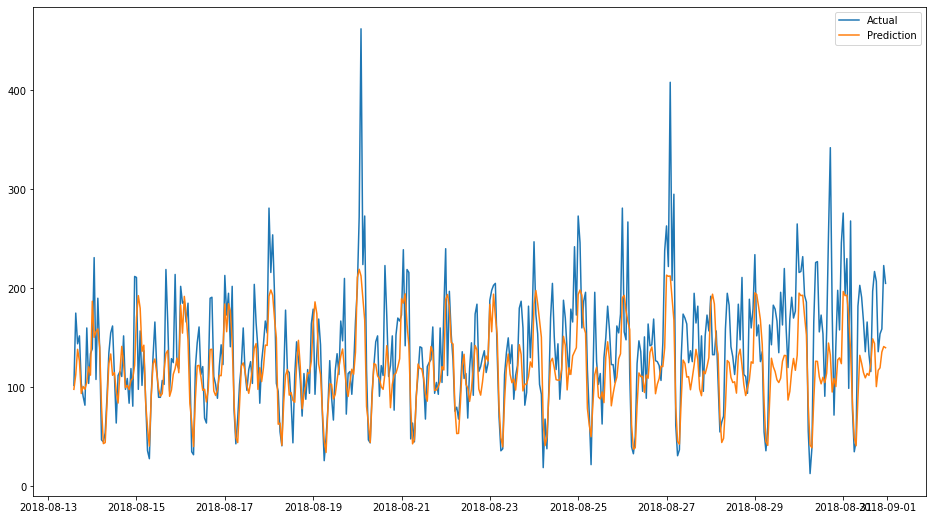

In [27]:
best_pred = mod_lgbm.predict(test_features)

print("RMSE:", mean_squared_error(test_target, best_pred) ** 0.5)
plt.figure(figsize=(16,9))
plt.plot(test_features.index, test_target, label='Actual')
plt.plot(test_features.index, best_pred, label='Prediction')
plt.legend()
plt.show()

На графике видно, что данная модель предсказывает данные с небольшими погрешностями, но в целом модель справилась неплохо. Цель достигнута, метрика RMSE не больше 48.